In [1]:
#Mathematics and statistics libraries

import math

import numpy as np
from numpy import array, dot, mean, std, hstack, asarray, exp, random
import numpy.random as npr
from numpy import linalg as LA
from numpy.linalg import inv
from numpy.random import normal

#import numba as nb
#from numba import guvectorize
import random
from random import randint, gauss, seed

from scipy import signal
from scipy import stats as ss
from scipy.stats import skew, kurtosis, norm, laplace, cauchy, uniform, expon, gamma
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.sparse
from scipy.sparse.linalg import spsolve
import scipy.special as scsp
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize, Bounds

import statistics
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# plotting/graphing related libraries

#data management
import pandas as pd
import yfinance as yf

#plotting and graphing libraries
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from pylab import plt, mpl

#3d graphs
import mpl_toolkits.mplot3d as mpl 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import time

from datetime import datetime, date, timedelta, timezone
#
from IPython.display import display, HTML
from IPython.display import Math
import sympy as sym
from sympy import symbols, exp

import openpyxl
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

import bt
import cvxpy as cvx

import cvxopt
from qpsolvers import solve_qp
import qpsolvers
from cvxopt import matrix, solvers



%matplotlib inline
#Math(r"x_t = x_{t - 1} \cdot e^{{r-0.5*\sigma^2}/2} \cdot dt + \sigma/2 * \sqrt{dt} * \varphi (t)")

In [2]:
# dates in correct format for yahoo finance.
today = date.today()
today = datetime(today.year,today.month,today.day - 1) #today
one = datetime(today.year-1,today.month,today.day) #one year ago
three = datetime(today.year-3,today.month,today.day) #three years ago
five = datetime(today.year-5,today.month,today.day) #five years ago
ten = datetime(today.year-10,today.month,today.day) #ten years ago
twenty = datetime(today.year-20,today.month,today.day) #twenty years ago

Portfolio library

In [3]:
def portfolio_volatility(weights, covmat):
    w = np.array(weights)
    covmat = np.asarray(covmat)
    return np.dot(np.dot(w.T, covmat), weights) ** 0.5

# We first need to define the risk contribution function, which measures the % contribution of risk of each asset to the total portfolio volatility

def risk_contribution(weights: pd.DataFrame, covmat: pd.DataFrame):
    """
    Computes the contribution to risk of the constituents of a portfolio

    Parameters
    ----------
    w: portfolio weights
    covmat: covariance matrix

    Returns
    -------
    Contribution to risk of each constituent
    """
    
    w = np.array(weights).reshape(-1, 1)
    cov = np.asarray(covmat)

    port_var = portfolio_volatility(w, cov) ** 2
    # Marginal contribution to risk
    mcr = np.dot(cov, w)
    # Percentage contribution to risk     
    cr = np.multiply(mcr, w) / port_var
    
    return cr

# Now, we have to define the function to be optimized.
# This is the function we are going to feed the optimizer with

def risk_budjet_error(weights, covmat):
    perc_risk_cont = risk_contribution(weights, covmat).ravel()
    n_assets = covmat.shape[0]
    risk_target = np.array([1 / n_assets] * n_assets)  # The target risk for each asset is equal to the portfolio risk / n of assets
    j = sum(np.square(risk_target - perc_risk_cont))  # sum of squared errors
    return j

# The optimization function

def optimize(func, covmat, target_return=None, allow_short=False):
    init_weights = [1 / covmat.shape[0]] * covmat.shape[0]  # initialize weights array

    opt_bounds = Bounds(0, 1) if not allow_short else None  # Constraint on short selling

    opt_constraints = {'type': 'eq',
                       'fun': lambda w: 1.0 - np.sum(w)}  # the weights need to sum up to 100%
    
    if target_return is not None:  # add a constraint to meet a specific target return. Default as False as it might result in no solutions 
                                   # to the optimization problem
        opt_constraints = ({'type': 'eq',
                            'fun': lambda w: 1.0 - np.sum(w)},
                           {'type': 'eq',
                            'fun': lambda w: target_return - w.T @ exp_ret})

    optimal_weights = minimize(func,
                               init_weights,
                               args=(covmat),
                               method='SLSQP',
                               bounds=opt_bounds,
                               constraints=opt_constraints)

    return optimal_weights.x

def score(symbol):
    try:
        t = yf.Ticker(symbol)   
        div = t.dividends
        div = div.to_frame()
        div = div.tz_localize(None)
        mh = t.major_holders
        ih = t.institutional_holders  
        bs = t.balance_sheet
        fin = t.financials
        cs = t.cashflow
        options = t.options
        #opt = t.option_chain('2023-09-15')
        #calls = opt[0]
        #puts = opt[1]

        # points = 0
        p = 0

        # Hvis nogen af nedenstående er
        GIH = ["Vanguard", "Blackrock Inc.", "Berkshire Hathaway, Inc", "State Street Corporation", "Morgan Stanley", "Norges Bank Investment Management", "JP Morgan Chase & Company", "Goldman Sachs Group Inc", "Bank of America Corporation", "Pacer Advisors, Inc.", "iShares", "Fidelity"]
        if "Holder" in ih.columns:
            if len(ih['Holder']) > 0:
                for i in range(len(GIH)):
                    for j in range(len(ih['Holder'].tolist())):
                        if GIH[i] in ih['Holder'].tolist()[j]:
                            p = p + 1

        # hvis interne investorer holder mindre end 10% af alle aktier
        for i in range(3):
            if str(mh[0][i]) == "nan":
                mh[0][i] = 0
            elif "%" in str(mh[0][i]):
                mh[0][i] = mh[0][i].replace("%","")

        if float(mh[0][0]) < 10:
            p = p + 1

        # hvis institutioner holder mere end 50% af alle aktier
        if float(mh[0][1]) > 20 or float(mh[0][2]) > 20:
            p = p + 1

        if len(div) > 0:    

            divs = np.zeros(len(div))
            if div['Dividends'][0]/sdata(symbol, div.index[0],today).head(1)[0] < div['Dividends'][len(div)-1]/sdata(symbol, div.index[0],today).tail(1)[0]:
                p = p + 1

            divs = np.zeros(len(div))
            if div['Dividends'][int(round(len(div) / 2,0)) -1] / sdata(symbol, div.index[int(round(len(div) / 2,0)) -1], today)[0] < div['Dividends'][len(div)-1]/sdata(symbol, div.index[0],today).tail(1)[0]:
                p = p + 1

            if div['Dividends'][len(div)-1]/sdata(symbol, div.index[0],today).tail(1)[0] > 0.02:
                p = p + 1
            elif div['Dividends'][len(div)-1]/sdata(symbol, div.index[0],today).tail(1)[0] < 0.02:
                p = p - 1

            for i in range(1,len(div)):
                divs[i] = div['Dividends'][i] / div['Dividends'][i-1]

        
        bp = 0
        for i in range(3):
            #
            if 'Net Debt' in bs.index:
                if bs[bs.columns[i]]['Net Debt'] / bs[bs.columns[i+1]]['Net Debt'] < 1:
                    bp = bp + 1
                elif bs[bs.columns[i]]['Net Debt'] / bs[bs.columns[i+1]]['Net Debt'] > 1:
                    bp = bp - 1
            #
            if bs[bs.columns[i]]['Total Debt'] / bs[bs.columns[i+1]]['Total Debt'] < 1:
                bp = bp + 1
            elif bs[bs.columns[i]]['Total Debt'] / bs[bs.columns[i+1]]['Total Debt'] > 1:
                bp = bp - 1
            #
            if 'Long Term Debt' in bs.index:
                if bs[bs.columns[i]]['Long Term Debt'] / bs[bs.columns[i+1]]['Long Term Debt'] < 1:
                    bp = bp + 1
                elif bs[bs.columns[i]]['Long Term Debt'] / bs[bs.columns[i+1]]['Long Term Debt'] > 1:
                    bp = bp - 1
            #
            if 'Current Liabilities' in bs.index:
                if bs[bs.columns[i]]['Current Liabilities'] / bs[bs.columns[i+1]]['Current Liabilities'] < 1:
                    bp = bp + 1
                elif bs[bs.columns[i]]['Current Liabilities'] / bs[bs.columns[i+1]]['Current Liabilities'] > 1:
                    bp = bp - 1
            #
            if 'Current Debt' in bs.index and bs[bs.columns[i+1]]['Current Debt'] > 0:
                if bs[bs.columns[i]]['Current Debt'] / bs[bs.columns[i+1]]['Current Debt'] < 1:
                    bp = bp + 1
                elif bs[bs.columns[i]]['Current Debt'] / bs[bs.columns[i+1]]['Current Debt'] > 1:
                    bp = bp - 1
            #
            if 'Total Assets' in bs.index:
                if bs[bs.columns[i]]['Total Assets'] / bs[bs.columns[i+1]]['Total Assets'] > 1:
                    bp = bp + 1
                elif bs[bs.columns[i]]['Total Assets'] / bs[bs.columns[i+1]]['Total Assets'] < 1:
                    bp = bp - 1
            #
            if 'Current Assets' in bs.index:
                if bs[bs.columns[i]]['Current Assets'] / bs[bs.columns[i+1]]['Current Assets'] > 1:
                    bp = bp + 1
                elif bs[bs.columns[i]]['Current Assets'] / bs[bs.columns[i+1]]['Current Assets'] < 1:
                    bp = bp - 1
            
            if 'Total Capitalization' in bs.index:
                if bs[bs.columns[i]]['Total Capitalization'] / bs[bs.columns[i+1]]['Total Capitalization'] > 1:
                    bp = bp + 1
                elif bs[bs.columns[i]]['Total Capitalization'] / bs[bs.columns[i+1]]['Total Capitalization'] < 1:
                    bp = bp - 1
                    
            if 'Total Liabilities Net Minority Interest' in bs.index:
                if bs[bs.columns[i]]['Total Liabilities Net Minority Interest'] / bs[bs.columns[i+1]]['Total Liabilities Net Minority Interest'] > 1:
                    bp = bp + 1
                elif bs[bs.columns[i]]['Total Liabilities Net Minority Interest'] / bs[bs.columns[i+1]]['Total Liabilities Net Minority Interest'] < 1:
                    bp = bp - 1

            if 'Net Income' in fin.index:
                if fin[fin.columns[i]]['Net Income'] / fin[fin.columns[i+1]]['Net Income'] > 1:
                    bp = bp + 1
                elif fin[fin.columns[i]]['Net Income'] / fin[fin.columns[i+1]]['Net Income'] < 1:
                    bp = bp - 1

            if 'Total Revenue' in fin.index:
                if fin[fin.columns[i]]['Total Revenue'] / fin[fin.columns[i+1]]['Total Revenue'] > 1:
                    bp = bp + 1
                elif fin[fin.columns[i]]['Total Revenue'] / fin[fin.columns[i+1]]['Total Revenue'] < 1:
                    bp = bp - 1

            if 'Operating Revenue' in fin.index:
                if fin[fin.columns[i]]['Operating Revenue'] / fin[fin.columns[i+1]]['Operating Revenue'] > 1:
                    bp = bp + 1
                elif fin[fin.columns[i]]['Operating Revenue'] / fin[fin.columns[i+1]]['Operating Revenue'] < 1:
                    bp = bp - 1
                    
            if 'Normalized Income' in fin.index:
                if fin[fin.columns[i]]['Normalized Income'] / fin[fin.columns[i+1]]['Normalized Income'] > 1:
                    bp = bp + 1
                elif fin[fin.columns[i]]['Normalized Income'] / fin[fin.columns[i+1]]['Normalized Income'] < 1:
                    bp = bp - 1

            if 'Issuance Of Debt' in cs.index:
                if str(cs[cs.columns[i]]['Issuance Of Debt']) == "NaN":
                    cs[cs.columns[i]]['Issuance Of Debt'] = 0

            if 'Long Term Debt Issuance' in cs.index:
                if str(cs[cs.columns[i]]['Long Term Debt Issuance']) == "NaN":
                    cs[cs.columns[i]]['Long Term Debt Issuance'] = 0

            if cs[cs.columns[i]]['Operating Cash Flow'] > cs[cs.columns[i+1]]['Operating Cash Flow']:
                p = p + 1

            if 'Long Term Debt Payments' in cs.index and 'Long Term Debt Issuance' in cs.index:
                if abs(cs[cs.columns[i]]['Long Term Debt Payments']) > 0.5 * cs[cs.columns[i]]['Long Term Debt Issuance']:
                    p = p + 1

            if 'Repayment Of Debt' in cs.index and 'Issuance Of Debt' in cs.index:
                if abs(cs[cs.columns[i]]['Repayment Of Debt']) > 0.5 * cs[cs.columns[i]]['Issuance Of Debt']:
                    p = p + 1

            if bp < 0:
                p = p - 1
            elif bp > 10:
                p = p + 1
        
    except:
        p = 0
    return p    

def allocation(x):
    
    %matplotlib inline
    data = pd.DataFrame()
    returns = pd.DataFrame()
    Mreturns = pd.DataFrame()
    Sigma_diag = pd.DataFrame() 
    r=0
    Vfactor=len(portfolio)
    Vec1 = np.linspace(1,1,Vfactor)

    for x in portfolio:
        data[x] = sdata(x,one,today)
        returns[x] = (data[x]/data[x].shift(1)-1)
        Mreturns[x] = [float(np.mean(returns[x]))]
        Adays=len(data[data.columns[0]])-1
        Sigma_diag[x] = [Adays*returns.cov()[x][x]]

    VCM = returns.cov() * np.sqrt(Adays)
    Inv_VCM = inv(Adays*returns.cov())

    # Apply our risk parity function
    risk_parity_weights = optimize(risk_budjet_error, VCM)
    # Transform into DataFrame for ease of visualization
    risk_parity_weights = pd.DataFrame(risk_parity_weights, index=VCM.index, columns=["Weight"])
    risk_contr = pd.DataFrame(risk_contribution(risk_parity_weights, VCM), index = VCM.index, columns=["Contributions"])
    risk_info = pd.DataFrame()
    risk_info["Weights"] = risk_parity_weights
    risk_info["Contributions"] = risk_contr
    #
    p_vol = round(portfolio_volatility(risk_parity_weights, VCM)[0][0] * 100, 3)

    mean = Adays * Mreturns.iloc[0]
    STD = Sigma_diag.iloc[0]**.5
    risk_info['mean'] = mean
    risk_info['STD'] = STD

    a = Vec1.dot(Inv_VCM).dot(Vec1) #
    b = mean.dot(Inv_VCM).dot(Vec1) #
    sd_a = 1 / math.sqrt(a) #?
    m_a = b / a
    m_w = math.sqrt((mean - m_a * Vec1).T.dot(Inv_VCM).dot(mean - m_a * Vec1))
    m_r = math.sqrt((mean - r * Vec1).T.dot(Inv_VCM).dot(mean - r * Vec1))

    colors = np.random.rand(len(STD))
    fig, ax = plt.subplots()
    plt.scatter(STD, mean, c=colors, alpha=0.7)
    for i in range(0,len(STD)):
        ax.annotate(portfolio[i], (STD[i]+.01, mean[i]))

    range_inf = np.min(mean) - 0.05
    range_sup = np.max(mean) + 0.35
    z2 = np.linspace(range_inf, range_sup, 50)
    z1 = pd.DataFrame()
    z= pd.DataFrame()
    zr= pd.DataFrame()
    i=0
    for i in range(len(z2)):
        z1[i] = [math.sqrt( ((z2[i] - m_a)/m_w)**2 + sd_a**2)]
        z[i] = [(z2[i] - m_a)/m_w]
        zr[i] = [(z2[i] -r)/m_r]
    z1 = z1.iloc[0]
    z=z.iloc[0]
    zr=zr.iloc[0]


    plt.plot(z1,z2, alpha=1)
    plt.plot(z,z2, alpha=1)
    plt.plot(zr,z2, alpha=1)
    plt.legend(['points','Frontier', 'Asymptot', 'capital market line'], loc=2)
    plt.grid(True)
    plt.xlabel('annualised standard deviation')
    plt.ylabel('annualised return')
    plt.show()

    R = pd.DataFrame()
    Mean = pd.DataFrame()
    Covar = pd.DataFrame()
    R = data/data.shift(1)-1
    R = R[1:]
    Mean = R.mean()
    Covar = R.cov()

    Mean_A = pd.DataFrame()
    Covar_A = pd.DataFrame()
    n = len(R)
    d = len(data.columns)

    ##########################################################

    z = today - one
    m = float(n-1)
    delta = float(z.days)/365/m
    Covar_A = Covar/delta
    Mean_A = Mean/delta

    ########################################################

    m = 0.1 #expected return
    Q = matrix(array(2*Covar_A)) 
    p = matrix(np.zeros(d)) 
    G1 = np.diag([-1]*d)
    G2 = np.diag([1]*d)
    G = matrix(np.vstack([G1,G2]), tc="d")

    h = matrix(array([0]*d+[0.1]*d))
    A = matrix(array([Mean_A,[1]*d]))
    b = matrix(array([m,1]))

    sol = solvers.qp(Q, p, G, h, A, b)
    ask = []
    solv = sol['x']
    for i in range(0,len(solv)):
        ask.append(round(solv[i]*100,2))

    risk_info['Allocation'] = ask
    ask = pd.DataFrame(ask)
    Vec1 = [1]*d

    STAT = pd.DataFrame()
    STAT['Allocation'] = dot(sol['x'].T, Vec1) * 100
    STAT['Mean'] = dot(sol['x'].T, Mean_A)
    STAT['STD'] = np.sqrt( dot( sol['x'].T, dot(Q, sol['x']) )/2 )

    print(STAT)
    print(" ")
    print("Portfolio (ex-ante) annualized volatility is: {v}%".format(v=p_vol))
    return risk_info
    
def VAR(stock, start, end, invest):
    data = pd.DataFrame()
    for x in stock:
        data[x] = sdata(x, start, end)
    R = pd.DataFrame()
    Mean = pd.DataFrame()
    Covar = pd.DataFrame()
    R = data/data.shift(1)-1
    R = R[1:]
    Mean = R.mean()
    Covar = R.cov()


    avg_rets = Mean
    cov_matrix = array(Covar)
    weights = np.repeat(1/len(stock),len(stock))
    initial_investment = invest

    port_mean = float(avg_rets.dot(weights))
    port_stdev = float([np.sqrt(weights.T.dot(cov_matrix).dot(weights))][0])
    mean_investment = float([(1+port_mean)*initial_investment][0])
    stdev_investment = float([initial_investment*port_stdev][0])
    res = pd.DataFrame([port_mean, port_stdev, mean_investment, stdev_investment])
    res.index = ['Portfolio mean','Portfolio std','Investment mean','Investment std']
    res.columns = ['Stats']
    return res

Basic Stock data manipulation library

In [4]:
def sdata(x, y, z):
    # x is a stock symbol
    # y is a start date
    # z is an end date
    st = pd.DataFrame()
    t = yf.Ticker(x)
    st = t.history(start=y, end=z)['Close']
    st.index = pd.to_datetime(st.index).tz_localize(None)
    return st

def vdata(x,y,z):
    # x is a stock symbol
    # y is a start date
    # z is an end date
    st = pd.DataFrame()
    t = yf.Ticker(x)
    st = t.history(start=y, end=z)['Volume']
    st.index = pd.to_datetime(st.index).tz_localize(None)
    return st

def returns(x, logs = False):
    
    if type(x) == list:
        returne = np.zeros(len(x))
        for i in range(len(x)):
            returne[i] = ((x[i]/x[i-1])-1)
    elif type(x) == pd.DataFrame:
        returne = x.pct_change().dropna()
        
    else:
        returne = x.pct_change().dropna()
        
    if logs == True:
        returne = np.log(abs(returne))
    
    df = pd.DataFrame(data=returne, dtype='float64')
    df.columns = [x.name]
    return df

def smafull(x):
    MMA7 = np.zeros(len(x))
    MMA21 = np.zeros(len(x))
    MMA60 = np.zeros(len(x))
    MMA120 = np.zeros(len(x))
    for i in range(7,len(x)):
        MMA7[i] = float(np.mean(x[i-7:i]))
    for i in range(21,len(x)):
        MMA21[i] = float(np.mean(x[i-21:i]))
    for i in range(60,len(x)):
        MMA60[i] = float(np.mean(x[i-60:i]))
    for i in range(120, len(x)):
        MMA120[i] = float(np.mean(x[i-120:i])) 
        
    for i in range(0, len(x)):
        if MMA7[i] == 0:
            MMA7[i] = x[i]
        if MMA21[i] == 0:
            MMA21[i] = x[i]
        if MMA60[i] == 0:
            MMA60[i] = x[i]
        if MMA120[i] == 0:
            MMA120[i] = x[i]
    
    data = pd.DataFrame({'MMA7': MMA7,'MMA21': MMA21, 'MMA60': MMA60,'MMA120': MMA120,'Stockprice': x })
    return data

def updown(x):
    #plots
    short = np.zeros(len(x))
    long = np.zeros(len(x))
    for i in range(0,len(x)):
        if x['MMA120'][i] < x['Stockprice'][i]:
            long[i]=-1
        elif x['MMA120'][i] > x['Stockprice'][i]:
            long[i]=+1
        if x['MMA7'][i] < x['MMA21'][i]:
            short[i]=-1
        elif x['MMA7'][i] > x['MMA21'][i]:
            short[i]=+1
    
    data = pd.DataFrame({'short': short,'long': long })      
    return data

def sforecast(MD):
    if updown(MD)['short'][len(MD)-1] > 0:
        print("up-short")
    else:
        print("down-short")

    if updown(MD)['long'][len(MD)-1] > 0:
        print("up-long")
    else:
        print("down-long")
    times = []
    times_r = []

    timel = []
    timel_r = []

    uds = updown(MD)['short']
    udl = updown(MD)['long']

    for i in range(1,len(uds)):
        if uds[i] - uds[i-1] != 0:
            times.append(i)
        if udl[i] - udl[i-1] != 0:
            timel.append(i)

    timelrem = []
    for i in range(1,len(timel)):
        if timel[i] - timel[i-1] < 3:
            timelrem.append(timel[i])

    for x in timelrem:
        timel.remove(x)

    for i in range(1,len(timel)):
        timel_r.append(timel[i] - timel[i-1])
    for j in range(1,len(times)):
        times_r.append(times[j] - times[j-1])

    print("short mr-time:",np.mean(times_r))
    print("long mr-time:",np.mean(timel_r))
    
def smaplot(x):
    plt.figure(figsize=(18, 8))
    plt.plot(x['Stockprice'], lw=1, color="black") 
    plt.plot(x['MMA7'], lw=0.5,color="r") 
    plt.plot(x['MMA21'], lw=0.5,color="b") 
    plt.plot(x['MMA60'], lw=0.5,color="c") 
    plt.plot(x['MMA120'], lw=0.5,color="c") 
    plt.grid()
    plt.title("Moving averages")
    plt.xlabel('day')
    plt.ylabel('price')
    plt.show()
    
def wealth_plot(x):
    titel = "Wealth plot " + str(x.columns[0])
    plt.figure(figsize=(18, 8))
    plt.plot((x + 1).cumprod())
    plt.grid()
    plt.title(titel)
    plt.xlabel("Date")
    plt.ylabel("Wealth")
    plt.show()

def sma(x, window = 21,**kwargs):
    windo = kwargs.get('window', window)
    df = pd.DataFrame(index=x.index, dtype=np.float64)
    df.loc[:,0] = x.rolling(window=windo, center=False).mean().values.flatten()
    df.columns = ['SMA']
    return df

def ema(x, window = 21, **kwargs):
    spa = kwargs.get('span', window)
    df = pd.DataFrame(index=x.index, dtype=np.float64)
    df.loc[:,0] = x.ewm(span=spa, min_periods=0, adjust=True, ignore_na=False).mean().values.flatten()
    df.columns = ['EMA']
    return df

def volatility(x, window = 21, **kwargs):
    vol = np.zeros(len(x.index))
    _risk = pd.DataFrame(data=vol, index=x.index, dtype='float64')
    _risk.loc[:, 0] = x.rolling(center=False, window=kwargs.get('window', window)).std().values.flatten()
    return _risk

def bollinger(x, **kwargs):
    smadf = sma(x)
    sigmas = volatility(x)
    diff = 2 * sigmas
    Upper = smadf.iloc[:, 0].values + diff.iloc[:,0]
    Lower = smadf.iloc[:, 0].values - diff.iloc[:,0]
    bolldf = pd.DataFrame()
    bolldf['Lower'] = Lower
    bolldf['Upper'] = Upper
    return bolldf

def sharperatio(x):
    mu, sigma = x.mean(), np.sqrt(x.var())
    return (mu-5) / sigma

def backtester(x, windo = 21):
    weights = x.shift(1).rolling(window= windo).std().dropna() / np.mean(x)
    return (x * weights.shift(1)).sum()  
    
def station1(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=int(len(timeseries)/2)).mean()
    rolstd = pd.Series.rolling(timeseries, window=int(len(timeseries)/2)).std()
    #fig = plt.figure()
    #fig.add_subplot()
    #orig = plt.plot(timeseries, color = 'blue',label='Original')
    #mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    #std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    #plt.ylim([min(timeseries)-3*abs(np.mean(timeseries)),max(timeseries)+3*abs(np.mean(timeseries))])
    #plt.legend(loc = 'best')
    #plt.title('Rolling Mean & Standard Deviation')
    #plt.show(block=False)
    #print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    #print(dfoutput)
    if dfoutput['p-value'] > 0.05:
        res = "Non-stationary"
    else:
        res = "Stationary"
        
    if dfoutput['Test Statistic'] > dfoutput['Critical value (5%)']:
        res = "Non-stationary"
    else:
        res = "Stationary"
    return res

def station2(x):
    result = adfuller(x)
    #print('ADF Statistic: %f' % result[0])
    #print('p-value: %f' % result[1])
    #print('Critical Values:')
    #for key, value in result[4].items():
        #print('\t%s: %.3f' % (key, value))
    res = "Stationary"
    p = pd.DataFrame(result[4].items())[1]
    if result[1] > 0.1:
        res = "Non-stationary"
    #for i in range(len(p)):
        #if result[0] > p[i]:
            #print("Not within ", pd.DataFrame(result[4].items())[0][i])
    return res

In [5]:
def frequencies(data, bins, wp = False):
    #binning strategien skal opdateres på et senere tidspunkt
    if type(data) != pd.DataFrame:
        data = pd.DataFrame(data)
    
    m1 = min(data.iloc[:,0])
    m2 = max(data.iloc[:,0])    
    res1 = []
    res2 = []
    xlist = []
        
    for i in range(bins):
        k = 0

        inter1 = m1 + (i/bins) * (m2 - m1)
        inter2 = m1 + ((i+1) /bins) * (m2 -m1)
        xlist.append(round(inter2,5))

        for j in range(len(data)):
            if float(data.iloc[j,0]) > float(inter1) and float(data.iloc[j,0]) < float(inter2) :
                k = k + 1

        res1.append(round(int(k),5))
        res2.append(round(k/len(data),5))
    
    
    res = pd.DataFrame([res1,res2],index = ['Frequencies', 'Percentages'], columns = xlist)
    lst = np.linspace(m1, m2, bins)

    if wp == True:
        y_pos = np.arange(len(res.columns))
        plt.bar(y_pos, res.iloc[0], color ='navy', width = 1)
        plt.xticks(y_pos,res.columns)
        plt.ylabel("Frequencies")
        plt.xlabel("Percentage returns")
        plt.title("Frequencies")
        plt.plot(y_pos, res.iloc[0], color = 'maroon')
        plt.xticks(y_pos,res.columns)
        plt.tick_params(axis='both', which='major', labelsize=7)
    return res

def sstat(data, txt = "Stat"):
    m = pd.DataFrame([0])
    for n in range(0, 4):
        s = 0
        if n == 0:
            for j in range(len(data)):
                if type(data) == pd.Series:
                    s = s + data[j]
                elif type(data) == pd.DataFrame:
                    s = s + data.iloc[j,0]
            s = s/ len(data)

        elif n > 0:
            for j in range(len(data)):
                if type(data) == pd.Series:
                    s = s + (data[j] - m[0][0])**(n+1)
                elif type(data) == pd.DataFrame:
                    s = s + (data.iloc[j,0] - m[0][0])**(n+1)
            s = s / len(data)

        if n == 0 or n == 1:
            m[n] = s
        elif n>1:
            m[n] = s / (np.sqrt(m[1][0])**(n+1))
        
        if type(data) == pd.DataFrame:
            p = [data.describe().squeeze()[3],data.describe().squeeze()[4],data.describe().squeeze()[5],data.describe().squeeze()[6], data.describe().squeeze()[7]]
        else:
            p = [data.describe()[3],data.describe()[4],data.describe()[5],data.describe()[6],data.describe()[7]]

    mean = {'min':[p[0]],'25':[p[1]],'50':[p[2]],'75':[p[3]],'max':[p[4]],'Mean':[m[0][0]],'STD':[np.sqrt(m[1][0])], 'Variance':[m[1][0]], 'Skew':[m[2][0]], 'Kurtosis':[m[3][0]]}
    m = pd.DataFrame(mean, index = [str(txt)])
    return m

def seasonality(S):
    lst = [0,0,0,0,0,0,0,0,0,0,0,0]
    liste = []
    j = 0
    k = 0
    f = 0
    for i in range(len(S)):

        if int(str(S.index[i])[0:4]) > int(str(S.index[i-1])[0:4]):
            liste.append(lst)
            j = 0
            k = 0
            lst = [0,0,0,0,0,0,0,0,0,0,0,0]

        if int(str(S.index[i])[5:7]) > int(str(S.index[i-1])[5:7]) :
            j = 0
            k = 0

        j = j + 1   
        k = k + S[i]
        f = k/j

        lst[int(str(S.index[i])[5:7])-1] = f

    SS = pd.DataFrame(liste, columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAJ', 'JUN', 'JUL', 'AUG', 'SEP', 'OKT', 'NOV', 'DEC'])
    return SS

def seasonmax(x):
    lstmin = [0,0,0,0,0,0,0,0,0,0,0,0]
    lstmax = [0,0,0,0,0,0,0,0,0,0,0,0]
    for aar in range(len(x)): 

        for j in range(len(x.columns)):
            maan = x.columns[j]
            if x[maan][aar] == 0:
                break

            if x[maan][aar] == min(x.loc[aar]):
                lstmin[j] = lstmin[j] + 1

            elif x[maan][aar] == max(x.loc[aar]):
                lstmax[j] = lstmax[j] + 1

    LL = pd.DataFrame([lstmin,lstmax], columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAJ', 'JUN', 'JUL', 'AUG', 'SEP', 'OKT', 'NOV', 'DEC'], index = ['Min', 'Max'])
    return LL

CS: No data found, symbol may be delisted
C:\Users\Markb\AppData\Local\Temp\ipykernel_12440\3563521597.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  MR[y] = lste
C:\Users\Markb\AppData\Local\Temp\ipykernel_12440\3563521597.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  MR[y] = lste
C:\Users\Markb\AppData\Local\Temp\ipykernel_12440\3563521597.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

,NVDA,AMD,ABBV,MITT,AGNC,ALE,ALLY,MO,AEP,AXP,...,SYDB.CO,4502.T,HLAG.DE,7267.T,HSBA.L,IMB.L,ISP.MI,SBRY.L,105560.KS,MEAN
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.985782,1.982650,2.017657,2.182292,2.050571,2.027419,2.043902,2.074257,2.081126,2.037277,...,2.135043,2.145870,2.156997,2.069492,1.934049,2.091211,2.007899,2.130068,2.081081,2.079492
2,2.774834,2.762637,2.750547,2.774834,2.668790,2.714903,2.714903,2.726681,2.762637,2.812081,...,2.806742,2.677632,2.853273,2.872941,2.594650,2.711828,2.843400,2.865909,2.719647,2.734905
3,3.299213,3.369973,3.425068,3.434426,3.214834,3.158291,3.198473,3.481994,3.248062,3.388140,...,3.403270,3.420168,3.335092,3.291105,3.216837,3.292428,3.416667,3.454795,3.366120,3.278258
4,3.891641,3.867692,3.797583,4.232323,3.729970,3.752239,3.774775,3.990476,3.797583,3.844037,...,3.940063,3.827586,3.974843,3.990196,3.602857,3.697947,4.167213,3.856269,3.733333,3.768735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,57.136364,39.281250,26.187500,29.928571,26.187500,35.914286,35.914286,32.230769,21.305085,27.933333,...,36.735294,26.543478,60.190476,16.065789,70.055556,40.677419,42.366667,31.525000,24.640000,37.863179
196,62.850000,39.281250,25.140000,31.425000,27.326087,38.090909,38.090909,33.972973,21.305085,29.232558,...,36.735294,27.750000,60.190476,16.065789,70.055556,40.677419,42.366667,33.184211,26.782609,38.123399
197,62.850000,41.900000,28.568182,31.425000,28.568182,35.914286,35.914286,33.972973,21.305085,30.658537,...,36.735294,27.750000,60.190476,16.065789,70.055556,40.677419,42.366667,31.525000,26.782609,38.315693
198,57.136364,36.970588,28.568182,34.916667,27.326087,35.914286,35.914286,35.914286,22.052632,30.658537,...,36.735294,27.750000,60.190476,16.500000,63.050000,38.212121,45.392857,31.525000,26.782609,38.297594


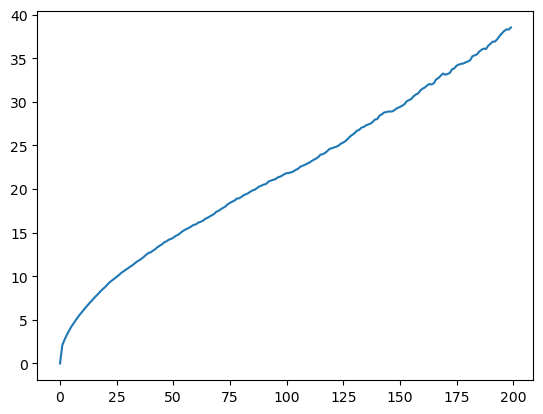

In [9]:
portfolio = pd.read_excel(open('list.xlsx', 'rb'), sheet_name='Ark1')
portfolio = portfolio['Symbols'].tolist()
portfolio = portfolio[0:300]

MR = pd.DataFrame()

for y in portfolio:
    
    x = sdata(y,five,today)
    
    lst = []
    for i in range(len(x)):
        lste = np.zeros(200)
        for j in range(1,200):
            if i >= j:
                lste[j] = np.mean(x[i-j:i])
        lst.append(lste)

    lst = pd.DataFrame(lst)
    lst[0] = list(x)




    lste = np.zeros(200)
    for i in range(1,len(lst)):

        for j in range(1,200):

            if lst[j][i] > lst[0][i] and lst[j][i-1] < lst[0][i-1]:
                lste[j] = lste[j] + 1
            elif lst[j][i] < lst[0][i] and lst[j][i-1] > lst[0][i-1]:
                lste[j] = lste[j] + 1

            if i == (len(lst)-1):
                lste[j] = len(lst) / lste[j]
                   
    MR[y] = lste

mean = []
for i in range(len(MR)):
    mean.append(np.mean(MR.loc[i]))
MR['MEAN'] = mean
display(MR)
plt.plot(MR.index, MR['MEAN'])


MRE = MR['MEAN']
MRE.to_excel('MRE.xlsx', sheet_name='MRE')

In [13]:
def g(x):
    return 1+x**(2/3)

for i in range(25,200):
    if g(i)*0.95 < MRE[i] and g(i)*1.5 > MRE[i]:
        print(i, "within 5%")

25 within 5%
26 within 5%
27 within 5%
28 within 5%
29 within 5%
30 within 5%
31 within 5%
32 within 5%
33 within 5%
34 within 5%
35 within 5%
36 within 5%
37 within 5%
38 within 5%
39 within 5%
40 within 5%
41 within 5%
42 within 5%
43 within 5%
44 within 5%
45 within 5%
46 within 5%
47 within 5%
48 within 5%
49 within 5%
50 within 5%
51 within 5%
52 within 5%
53 within 5%
54 within 5%
55 within 5%
56 within 5%
57 within 5%
58 within 5%
59 within 5%
60 within 5%
61 within 5%
62 within 5%
63 within 5%
64 within 5%
65 within 5%
66 within 5%
67 within 5%
68 within 5%
69 within 5%
70 within 5%
71 within 5%
72 within 5%
73 within 5%
74 within 5%
75 within 5%
76 within 5%
77 within 5%
78 within 5%
79 within 5%
80 within 5%
81 within 5%
82 within 5%
83 within 5%
84 within 5%
85 within 5%
86 within 5%
87 within 5%
88 within 5%
89 within 5%
90 within 5%
91 within 5%
92 within 5%
93 within 5%
94 within 5%
95 within 5%
96 within 5%
97 within 5%
98 within 5%
99 within 5%
100 within 5%
101 within 

up-short
up-long
short mr-time: 17.884057971014492
long mr-time: 71.0


,min,25,50,75,max,Mean,STD,Variance,Skew,Kurtosis
Stock,89.566994,146.480591,230.296463,279.006622,358.730469,218.594470,72.942751,5320.644921,-0.130201,1.819539
Returns,-0.147390,-0.008631,0.000962,0.011149,0.142169,0.001054,0.019752,0.000390,0.025057,9.331093


Stock is right heavy, thin-tailed, Laplace distributed with: 230.29646 62.30417 Stock prices are Non-stationary
Returns is left heavy, fat-tailed, Cauchy distributed with: 231.49772 50.84361 Stock returns are Stationary


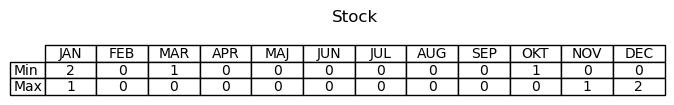

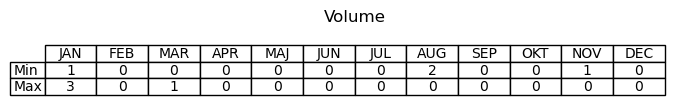

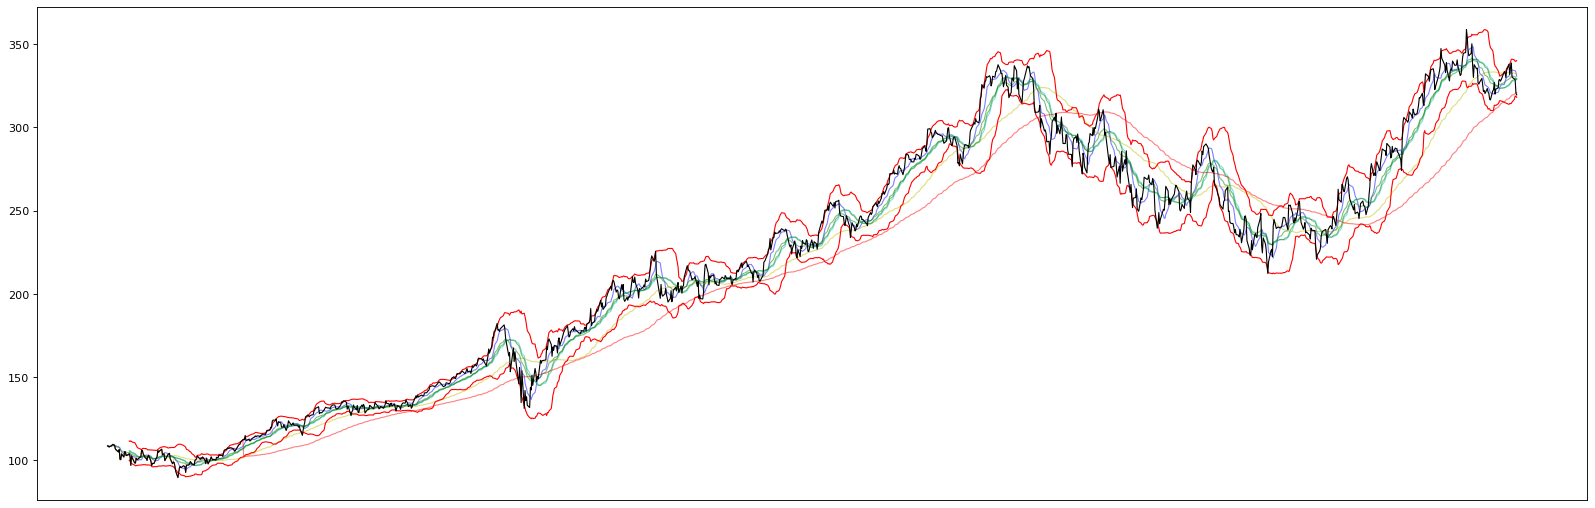

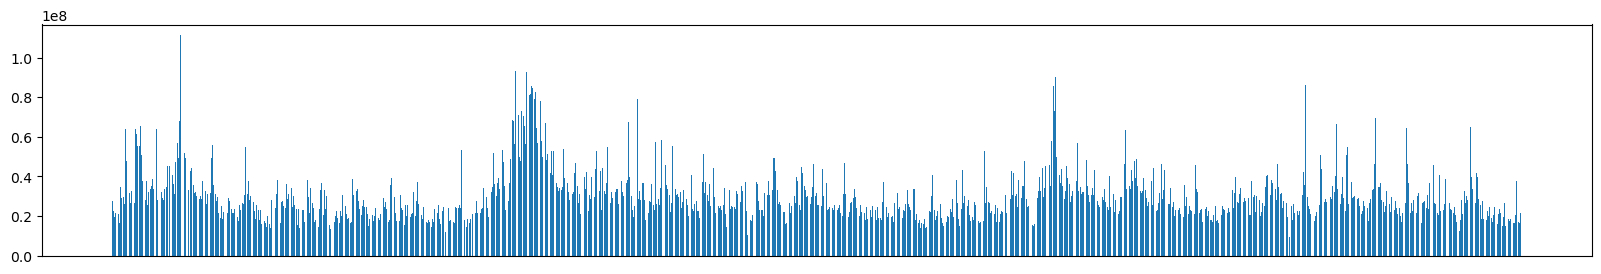

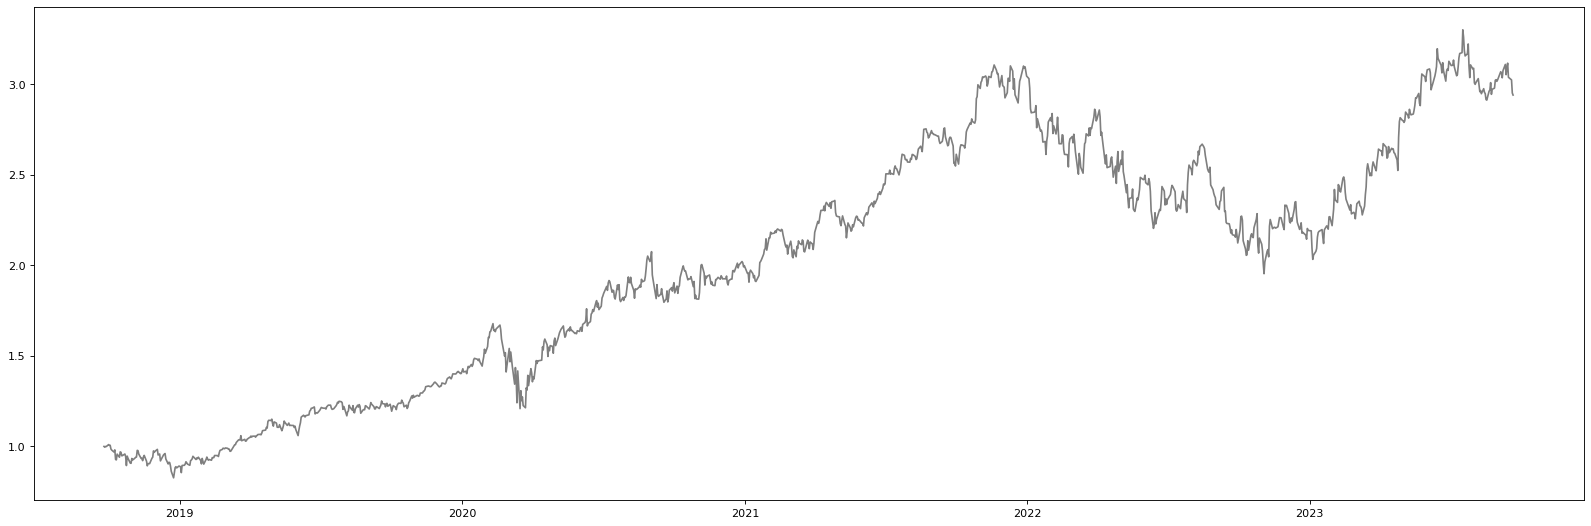

In [8]:
Stocks20y = pd.DataFrame()
Stocks10y = pd.DataFrame()
Stocks5y = pd.DataFrame()
Stocks3y = pd.DataFrame()
Stocks1y = pd.DataFrame()

Tickers = ['MSFT']

for x in Tickers:
    Stocks20y[x] = sdata(x,twenty,today)
    Stocks10y[x] = sdata(x,ten,today)
    Stocks5y[x] = sdata(x,five,today)
    Stocks3y[x] = sdata(x,three,today)
    Stocks1y[x] = sdata(x,one,today) 
    
    S = Stocks5y[x]
    r = returns(S)
    V = vdata(x, five, today)
    options = yf.Ticker(Tickers[0]).option_chain()
    OptC = options.calls
    OptP = options.puts

    SS = seasonality(S)
    SSM = seasonmax(SS)

    VS = seasonality(V)
    VSM = seasonmax(VS)
    
    MA = smafull(S)
    sforecast(MA)

    s = sstat(S,"Stock")
    rs = pd.DataFrame(r)
    rs = sstat(r,"Returns")
    s = pd.concat([s,rs])
    
    m = pd.DataFrame()
    m['Actual'] = S
    m['Returns'] = r
    m['SMA'] = sma(S)
    m['EMA'] = ema(S)
    m['VOLIT'] = volatility(S)
    m['Lower'] = bollinger(S)['Lower']
    m['Upper'] = bollinger(S)['Upper']
    
    
    display(s)
    
    
    for i in [0,1]:
        c = [0,0]
        res = ""
        if s['Skew'][i] == 0 and s['Kurtosis'][i] == 3:
            c[0] = round(norm.fit(S)[0],5)
            c[1] = round(norm.fit(S)[1],5)
            res = str(s.index[i])+" is normal distributed with:"+ str(c[0])+ str(c[1])
        elif s['Skew'][i] > 0 and s['Kurtosis'][i] < 3:
            c[0] = round(laplace.fit(S)[0],5)
            c[1]= round(laplace.fit(S)[1],5)
            res = str(s.index[i]) +" is left heavy, thin-tailed, Laplace distributed with: " + str(c[0]) +" "+ str(c[1])
        elif s['Skew'][i] > 0 and s['Kurtosis'][i] > 3:
            c[0] = round(cauchy.fit(S)[0],5)
            c[1] = round(cauchy.fit(S)[1],5)
            res = str(s.index[i]) + " is left heavy, fat-tailed, Cauchy distributed with: " + str(c[0]) +" "+ str(c[1])
        elif s['Skew'][i] < 0 and s['Kurtosis'][i] < 3:
            c[0]= round(laplace.fit(S)[0],5)
            c[1] = round(laplace.fit(S)[1],5)
            res = str(s.index[i])+" is right heavy, thin-tailed, Laplace distributed with: "+ str(c[0]) +" "+ str(c[1])
        elif s['Skew'][i] < 0 and s['Kurtosis'][i] > 3:
            c[0] = round(cauchy.fit(S)[0],5)
            c[1] = round(cauchy.fit(S)[1],5) 
            res = str(s.index[i])+" is right heavy, fat-tailed, Cauchy distributed with: "+ str(c[0]) +" "+ str(c[1])
        else:
            res = str("we don't know about this one "+s.index[i]) 
        
        if i == 0:
            res = res + " Stock prices are " + station1(S)
        elif i == 1:
            res = res + " Stock returns are " + station1(r)
        
        print(res)
        
    
    fig = plt.figure(figsize = (8, 0.2))
    plt.table(cellText = SSM.values, rowLabels = SSM.index, 
             colLabels = SSM.columns, cellLoc='center')
    plt.title('Stock')
    plt.axis('off')
    
    fig = plt.figure(figsize = (8, 0.2))
    plt.table(cellText = VSM.values, rowLabels = VSM.index, 
             colLabels = VSM.columns, cellLoc='center')
    plt.title('Volume')
    plt.axis('off')
    
    
    #
    plt.figure(figsize=(25, 8), dpi=80)
    plt.plot(MA.index, MA['MMA7'], color = 'b', alpha = 0.5, lw=1)
    plt.plot(MA.index, MA['MMA21'], color = 'c', alpha = 0.5, lw=1)
    plt.plot(MA.index, MA['MMA60'], color = 'y', alpha = 0.5, lw=1)
    plt.plot(MA.index, MA['MMA120'], color = 'r', alpha = 0.5, lw=1)
    plt.plot(m.index, m['SMA'], color = 'g', alpha = 0.5, lw=1)
    plt.plot(m.index, m['EMA'], color = 'g', alpha = 0.5, lw=1)
    plt.plot(m.index, m['Lower'], color = 'r', alpha = 1, lw=1)
    plt.plot(m.index, m['Upper'], color = 'r', alpha = 1, lw=1)
    plt.plot(MA.index, MA['Stockprice'], color = 'k', alpha = 1, lw=1)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.show()
    
    #
    fig = plt.figure(figsize = (20,3))
    plt.bar(V.index, V, width = 1)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.show()
    #
    
    #
    plt.figure(figsize=(25, 8), dpi=80)
    plt.plot((returns(MA['Stockprice']) + 1).cumprod(), color = 'k', alpha = 0.5)
    plt.show()
    
    
    #freq = frequencies(data, 10, True)
    #print(freq)


if skew is negative, than distribution is negatively tilted, opposite for positive
kurtosis < 3 is fat tailed
kurtosis > 3 is thin tailed.

In [ ]:
def f1(x):
    return model.intercept_ + x*model.coef_[1]

def f2(x):
    res = 0
    if len(results.params) <= 2:
        res = results.params[0] + results.params[1] *x   
    elif len(results.params) == 3:
        res = results.params[0] + results.params[1] *x + results.params[2] * x**2
    elif len(results.params) == 4:
        res = results.params[0] + results.params[1] *x + results.params[2] * x**2 + results.params[3] * x**3
    elif len(results.params) == 5:
        res = results.params[0] + results.params[1] *x + results.params[2] * x**2 + results.params[3] * x**3 + results.params[4] * x**4
    return res

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data = sdata("AAPL", three, today)
data = data.fillna(np.mean(data))
data[abs(data[0:]) < 0.01] = 0.01
df_all = pd.DataFrame()
df = pd.DataFrame()
df_all['Close'] = data
df_all['Diff']=df_all['Close']-df_all['Close'].shift(1)
df_all['LogClose']=np.log(abs(df_all['Close']))
df_all['LogDiff']=df_all['LogClose']-df_all['LogClose'].shift(1)
df=df_all[1:]
ts=df[['Close']]

resid = []
for n in range(12):
    residualer = []
    start = n*20 + 1
    end = (n+1)*20
        
    for i in range(start, end):
        x = np.array(range(2)).reshape((-1,1))
        y = np.array([data[i], data[i-1]])

        polynomial_features= PolynomialFeatures(degree=(4))
        xp = polynomial_features.fit_transform(x)
        xp.shape
        results = sm.OLS(y, xp).fit()

        x_ = PolynomialFeatures(degree=(1)).fit_transform(x)
        model = LinearRegression().fit(x_, y)

        r_sq = round(model.score(x_, y),3)
        model.intercept_
        model.coef_
        #print(f"SKlearn coefficient of determination: {r_sq}, if below 0.9, than it's bad")
        #print(f"SKlearn intercept: {model.intercept_}")
        #print(f"SKlearn slope: {model.coef_}")

        #print(f"Statsmodels coefficient of determination: {results.rsquared}, if below 0.9, than it's bad")
        #print(f"Statsmodels intercept: {results.params[0]}")
        #print(f"Statsmodels slope: {results.params}")

        xplot = np.linspace(0,2,10)
        yplot = []
        y2plot = []
        for j in range(len(xplot)):
            yplot.append(f1(xplot[j]))
            y2plot.append(f2(xplot[j]))

        residualer.append([(yplot[-1] - data[i+1]), (y2plot[-1] - data[i+1])])
    residualer = pd.DataFrame(residualer)
    residualer.columns = ["Linear","4D poly."]
    resid.append([ (np.mean(residualer["Linear"])/np.mean(data[start:end])), (np.mean(residualer["4D poly."])/np.mean(data[start:end]))  ])
    print("Month",n+1,", Linear",resid[n][0]*100,"%, 4D poly.", resid[n][1]*100,"%")
    
print(" ")
pm = 0
lm = 0
for i in range(len(resid)):
    pm = pm + resid[i][1]
    lm = lm + resid[i][0]
pm = pm/len(resid)
lm = lm/len(resid)
print("Mean of all linear residuals",lm,"\nMean of all Polynomial residuals", pm)

In [ ]:
lst = data.values.tolist()
for _ in range(3):
    lst.append(data.tail(1)[0])
    
    
    
data = sdata("AAPL", one, today)
data = data.fillna(np.mean(data))
df_all = pd.DataFrame()
df_all['Close'] = data
df_all['Diff']=df_all['Close']-df_all['Close'].shift(1)
df_all['LogClose']=np.log(df_all['Close'])
df_all['LogDiff']=df_all['LogClose']-df_all['LogClose'].shift(1)
df_all=df_all[1:]

diff=df_all[['Diff']]
diff = diff.fillna(0)

ts=df_all[['Close']]

tsf=ts.asfreq('b');
tsf[tsf.isnull().any(axis=1)];
tsf.ffill(inplace=True);
tsf.index = pd.to_datetime(tsf.index).tz_localize(None)

ts_dec=seasonal_decompose(tsf,  extrapolate_trend = 'freq')
tst = pd.DataFrame(ts_dec.trend)
tsr = pd.DataFrame(ts_dec.resid)

ts_rest=tsf['Close']
N=int(len(ts_rest)    )
sample_rate=500 # Hertz=cycles per second (frequecy)
#set d (sample spacing) = inverse of the sampling rate
d=1/sample_rate
duration=  N*d  #seconds
ts_fft=fft(ts_rest.values)
ts_freq=fftfreq(N,  d)  # Return the Discrete Fourier Transform sample frequencies (sample frequency POINTS)

ts_ifft=ifft(ts_fft)
c=[*ts_ifft, *ts_ifft]
ts_denoised=tst['trend'][0:]+ts_ifft


fig, axs = plt.subplots(figsize=(20, 8), ncols = 2, nrows = 1)
axs[0].plot(ts_freq[0:N//2] , ts_fft[0:N//2]  )
axs[1].plot(ts_rest.index, ts_ifft, color='b')
axs[1].plot(ts_rest.index, ts_rest, color='r', alpha=0.4)
plt.show()

# for function
sma={}
for k in [7, 21, 60]:
    sma[k]=ts.rolling(k).mean()


plt.figure(figsize=(20, 10))
#plt.plot(tst, color = "r")
plt.plot(ts_rest.index, ts_ifft, color='b')
plt.plot(ts['Close'].index, ts['Close'], color='k', lw=1,  alpha=0.5)
sma[7]['Close'].plot(color='xkcd:cyan',alpha=0.7)
sma[21]['Close'].plot(color='xkcd:aqua', alpha=0.7)
sma[60]['Close'].plot(color='xkcd:azure',alpha=0.7)
plt.show()

from scipy import stats
df_all['Close'].plot(kind = "kde")
sm.qqplot(df_all['Close'], line='q')
plt.show()

x = np.asarray(df_all['Close'])
plot_acf(x, lags=21)
plot_pacf(x, lags=21)

lag = 2
from statsmodels.api import stats
print(stats.acorr_ljungbox(x, lags=lag, return_df=True))
res_acf = stattools.acf(x, fft=True, qstat=True, nlags=lag)
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("acf", "qstat", "pvalues"))
fig.add_trace(
    go.Scatter(x=[i for i in range(len(res_acf[0]))],y=res_acf[0]),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=[i for i in range(len(res_acf[1]))], y=res_acf[1]),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=[i for i in range(len(res_acf[2]))],y=res_acf[2]),
    row=1, col=3
)


# for returns (function diffs)
plt.plot(diff.index, diff['Diff'])
plt.plot(diff.index,np.zeros(len(diff)),color = 'r')
plt.show()
diff.plot(kind = "kde")
plt.show()
from scipy import stats
sm.qqplot(diff, line='q');
plt.figure('QQ plot');
stats.probplot(diff['Diff'], plot=plt);
plt.show()
plot_acf(diff)
plot_pacf(diff);


#x = arima_process.arma_generate_sample(ar=[0.5, -0.25, -0.2], ma=[2], nsample=1000)

model1 = AutoReg(x, lags=2, old_names=False).fit()
model1 = ARIMA(endog=x, order=(1,1,1), trend='n').fit()
#model.summary()

n_test = 10
train, test = ts[:-n_test], ts[-n_test:]

model2 = arch_model(ts, mean='Zero', vol='ARCH', p=1).fit()
model3 = arch_model(ts, mean='Zero', vol='GARCH', p=1, q=1).fit()
model4 = arch_model(ts, vol='Garch', p=1, o=0, q=1, dist='Normal').fit()
#res = model.fit(disp='off')
yhat = model4.forecast(horizon=3)

#forecast_vol = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

#1: Perfect positive correlation. The variables tend to move in the same direction 
#(i.e., when one variable increases, the other variable also increases).

#0: No correlation. The variables do not have a relationship with each other.

#-1: Perfect negative correlation. The variables tend to move in opposite directions 
#(i.e., when one variable increases, the other variable decreases).

In [45]:
def independentBinomialLossDistribution(N,M,p,c,alpha):
    U = np.random.uniform(0,1,[M,N])
    defaultIndicator = 1*np.less(U,p)
    lossDistribution = np.sort(np.dot(defaultIndicator, c),axis=None)
    return lossDistribution

def computeRiskMeasures(M,lossDistribution,alpha):
    expectedLoss = np.mean(lossDistribution)
    unExpectedLoss = np.std(lossDistribution)
    expectedShortfall = np.zeros([len(alpha)])
    var = np.zeros([len(alpha)])
    for n in range(0,len(alpha)):
        myQuantile = np.ceil(alpha[n]*(M-1)).astype(int)
        eShortfall[n] = np.mean(lossDistribution[myQuantile:M-1])
        var[n] = lossDistribution[myQuantile]
    return expectedLoss, unExpectedLoss, var, eShortfall

def independentBinomialSimulation(N,M,p,c,alpha):
    lossDistribution = independentBinomialLossDistribution(N,M,p,c,alpha)
    el, ul, var, es = util.computeRiskMeasures(M,lossDistribtuion,alpha)
    return el, ul, var, es

def independentBinomialAnalytic(N,p,c,alpha):
    pmfBinomial = np.zeros(N+1)
    for k in range(0,N+1):
        pmfBinomial[k] = util.getBC(N,k)*(p**k)*((1-p)**(N-k))
    cdfBinomial = np.cumsum(pmfBinomial)
    varAnalytic = c*np.interp(alpha,cdfBinomial,np.linspace(0,N,N+1))
    esAnalytic = util.analyticExpectedShortfall(N,alpha,pmfBinomial,c)
    return pmfBinomial, cdfBinomial, varAnalytic, esAnalytic


def analyticExpectedShortfall(N,alpha,pmf,c):
    cdf = np.cumsum(pmf)
    numberDefaults = np.linspace(0,N,N+1)
    expectedShortfall = np.zeros(len(alpha))
    for n in range(0,len(alpha)):
        myAlpha = np.linspace(alpha[n],1,1000)
        loss = c*np.interp(myAlpha,cdf,numberDefaults)
        prob = np.interp(loss, numberDefaults,pmf)
        expectedShortfall[n] = np.dot(loss,prob)/np.sum(prob)
    return expectedShortfall

def independentPoissonLossDistribution(N,M,p,c,alpha):
    lam = -np.log(1-p)
    H = np.random.poisson(lam,[M,N])
    defaultIndicator = 1*np.greater_equal(H,1)
    lossDistribution = np.sort(np.dot(defaultIndicator,c),axis=None)
    return lossDistribution

def independentPoissonAnalytic(N,c,myLam,alpha):
    pmfPoisson = np.zereos(N+1)
    for k in range(0,N+1):
        pmfPoisson[k] = util.poissonDensity(myLam,k)
    cdfPoisson = np.cumsum(pmfPoisson)
    varAnalytic = c*np.interp(alpha,cdfPoisson, np.linspace(0,N,N+1))
    esAnalytic = util.analyticExpectedShortfall(N,alpha,pmfPoisson,c)
    return pmfPoisson, cdfPoisson, varAnalytic,esAnalytic

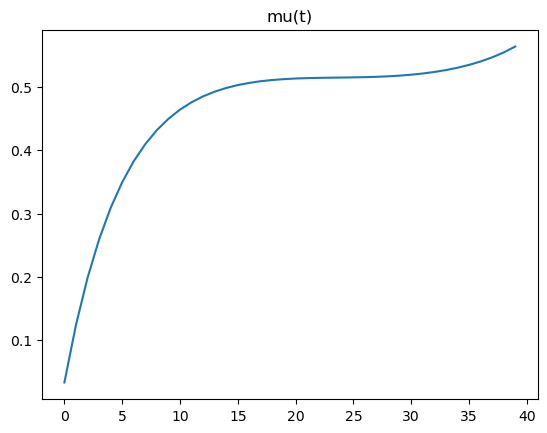

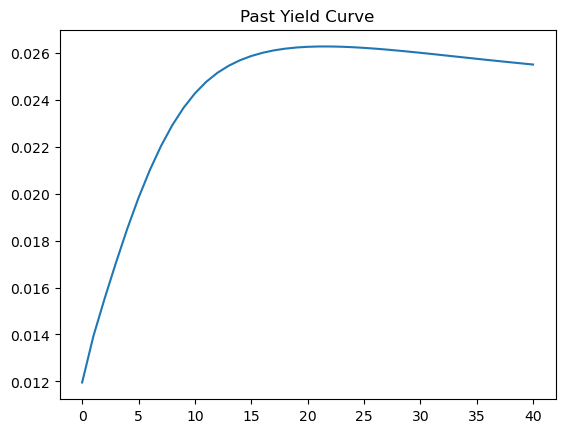

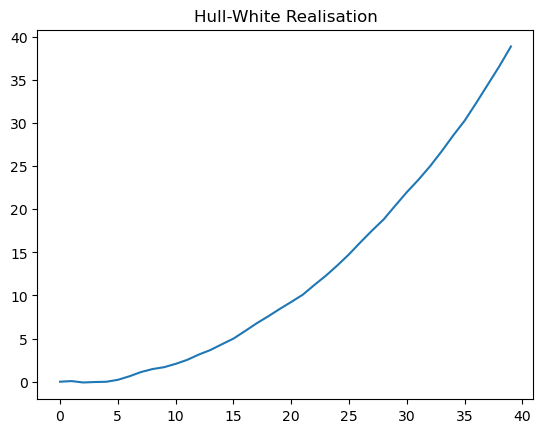

In [46]:
def hull_white_one_fac(r0, alpha, sigma, mu):
    dw = np.random.normal(size=40)
    dt = np.arange(0, 40)
    r = [r0]
    drt = [alpha * (mu[t] - r[-1]) * dt[t] + sigma * dw[t] for t in range(0, 40)]
    return r0 + np.cumsum(drt)

def hull_white_mu(yc, alpha, sigma):
    zcb = [(1+ir)**-t for ir, t in zip(yc, range(0, 40))]
    p = np.polyfit(range(0, 40), zcb, 4)
    #int_zcb = [p[0] * x**4 + p[1] * x**3 + p[2] * x**2 + p[3] * x + p[4] for x in range(0, 39)]
    int_fwd = [- (x * (x * (4 * p[0] * x + 3 * p[1]) + 2 * p[2]) + p[3])/(x * (x * (x * (p[0] * x + p[1]) + p[2]) + p[3]) + p[4]) for x in range(0, 40)]
    diff_int_fwd = [(-x * (4 * p[0] * x + 3 * p[1]) - x * (8 * p[0] * x + 3 * p[1]) - 2 * p[2])/(x * (x * (x * (p[0] * x + p[1]) + p[2]) + p[3]) + p[4]) - ((x * (x * (p[0] * x + p[1]) + p[2]) + x * (x * (p[0] * x + p[1]) + x * (2 * p[0] * x + p[1]) + p[2]) + p[3]) * (-x * (x * (4 * p[0] * x + 3 * p[1]) + 2 * p[2]) - p[3]))/(x * (x * (x * (p[0] * x + p[1]) + p[2]) + p[3]) + p[4])**2 for x in range(0, 40)]
    mu = [int_fwd_t + 1 / alpha * diff_int_fwd_t + sigma**2 / (2 * alpha**2) * (1 - math.exp(-2 * alpha * t)) for int_fwd_t, diff_int_fwd_t, t in zip(int_fwd, diff_int_fwd, range(0, 40))]
    return mu

if __name__ == '__main__': #previous yield curve
    yc = [0.0119570319370659, 0.013932701452346, 0.0155402499730131, 0.0170571519360345, 0.0184980810473157,
          0.0198172195995803, 0.0209961254997071, 0.0220294317532332, 0.0229150185187919, 0.0236552422871417,
          0.0242647899419137, 0.0247564999995886, 0.0251425189780907, 0.0254435362824561, 0.0256775380876704,
          0.0258580239023412, 0.0259953222775315, 0.0260974691351983, 0.0261708094460174, 0.026220418849926,
          0.0262504051003476, 0.0262641274856628, 0.0262643591390461, 0.0262534088604249, 0.0262332156314007,
          0.0262054249416492, 0.0261714378113969, 0.0261324526863991, 0.0260895002981996, 0.0260434715696152,
          0.0259951401334477, 0.0259451806407383, 0.0258941837503939, 0.0258426684823296, 0.0257910924605755,
          0.0257398604560517, 0.0256892937533311, 0.0256395310703303, 0.0255906600981819, 0.0255427589299506,
          0.0254958972440893]
    
    #yc2 = download somwhere t = 40
    
    a = 0.1 # alpha
    s = 0.1 # sigma
    r0 = yc[0]

    mu = hull_white_mu(yc, a, s)

    hw = hull_white_one_fac(r0, a, s, mu)

    plt.plot(mu)
    plt.title("mu(t)")
    plt.show()

    plt.plot(yc)
    plt.title("Past Yield Curve")
    plt.show()

    plt.plot(hw)
    plt.title("Hull-White Realisation")
    plt.show()

In [47]:
aapl = yf.Ticker('aapl')
options = aapl.option_chain()
#options

In [48]:
EURUSD = yf.Ticker('EURUSD=X').history(start=one, end=today)['Close']
#EURUSD

## This is setting up a portfolio

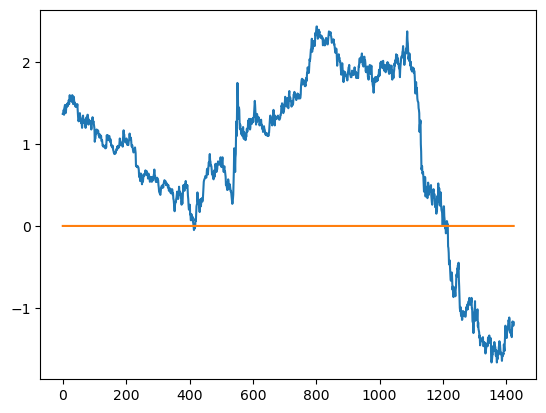

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,INYC,INYC2
1404,5.55,5.52,5.56,5.53,5.56,5.37,4.96,4.64,4.36,4.29,4.19,4.46,4.29,-1.27,0.771583
1405,5.53,5.52,5.56,5.51,5.55,5.36,4.92,4.64,4.36,4.31,4.21,4.49,4.32,-1.24,0.776978
1406,5.52,5.53,5.56,5.54,5.54,5.37,4.97,4.68,4.42,4.37,4.28,4.55,4.38,-1.18,0.787770
1407,5.55,5.52,5.56,5.54,5.53,5.36,4.94,4.67,4.42,4.38,4.30,4.58,4.41,-1.15,0.793165
1408,5.53,5.52,5.55,5.54,5.52,5.35,4.92,4.63,4.38,4.34,4.26,4.55,4.38,-1.17,0.789189
1409,5.55,5.53,5.57,5.55,5.58,5.37,4.97,4.70,4.46,4.42,4.34,4.64,4.45,-1.12,0.798923
1410,5.54,5.53,5.57,5.55,5.57,5.39,5.02,4.75,4.49,4.44,4.34,4.61,4.42,-1.15,0.793537
1411,5.54,5.53,5.57,5.56,5.55,5.35,4.95,4.64,4.36,4.30,4.19,4.46,4.27,-1.30,0.766607
1412,5.55,5.53,5.58,5.57,5.59,5.39,4.98,4.69,4.39,4.34,4.23,4.49,4.30,-1.28,0.770609
1413,5.56,5.53,5.61,5.59,5.61,5.44,5.03,4.72,4.44,4.37,4.25,4.50,4.30,-1.31,0.766488


In [49]:
yc = pd.read_csv('yc.csv')
yc = pd.DataFrame(yc)
yc['Date']  = pd.to_numeric(yc['Date'])
yc = yc.sort_values(by='Date', ascending=True)
yc = yc.set_index('Date')
yc = yc.reset_index(drop=True)
yc['INYC'] = yc['30 Yr'] - yc['3 Mo'] 
yc
plt.plot(yc.index, yc['INYC'])
plt.plot(yc.index, np.zeros(len(yc.index)))
plt.show()
yc['INYC2'] = yc['30 Yr'] / yc['3 Mo'] 
yc.tail(20)

In [57]:
portfolio = pd.read_excel(open('list.xlsx', 'rb'), sheet_name='list')
portfolio = portfolio['Symbols'].tolist()

points = []

for j in portfolio:
    points.append([j,score(j)])
    
points = pd.DataFrame(points)
points.columns = ["Symbols","Points"]
points.to_excel('list.xlsx', sheet_name='list')

portfolio = []
for i in range(len(points)):
    if points['Points'][i] >= 15:
        portfolio.append(points['Symbols'][i])

DNA.OL: No timezone found, symbol may be delisted


In [58]:
portfolio
VAR(portfolio, one, today, 100)

['ABBV',
 'AXP',
 'TSLA',
 'BBVA',
 'BAC',
 'CVX',
 'CSCO',
 'CFG',
 'KO',
 'SPG',
 'DOW',
 'IBM',
 'PFE',
 'UPS',
 'VALE',
 'COF',
 'AMT',
 'SNY',
 'MCHP',
 'PANW',
 'VRTX',
 'FAST',
 'ADP',
 'SNPS',
 'AVGO',
 'ON',
 'DIS',
 'MATX',
 'MAERSK-B.CO',
 'VOD.L',
 'ALV.DE',
 'RBI.VI',
 'ABN.AS',
 'SRG.MI',
 'BP.L',
 'BARC.L',
 'TBCG.L',
 '8001.T',
 '8316.T',
 '8411.T',
 'WBC.AX',
 'NAB.AX',
 'CBA.AX',
 '0823.HK',
 '2628.HK',
 '6752.T',
 'TOSBF',
 'BR',
 'ANA.MC',
 'ACX.MC',
 'IDR.MC',
 'BAYN.DE',
 'SKF-B.ST',
 'NDA-SE.ST',
 'TELIA.ST',
 'SBB-B.ST',
 'GIVN.SW',
 'GEBN.SW']

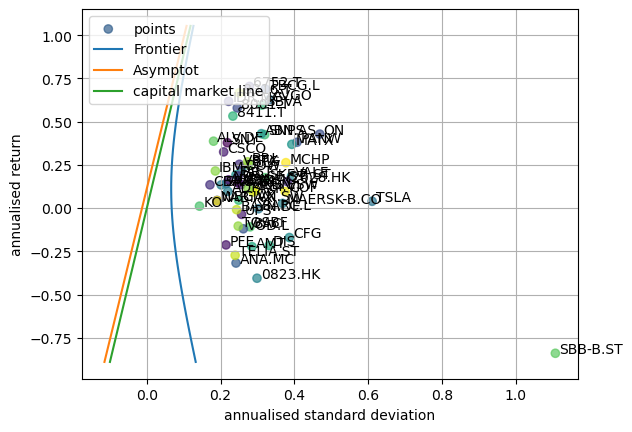

   Allocation  Mean       STD
0       100.0   0.1  0.078159
 
Portfolio (ex-ante) annualized volatility is: 2.608%
23


,Weights,Contributions,mean,STD,Allocation
ABBV,0.034153,0.017354,0.142618,0.215824,9.96
CSCO,0.016179,0.017268,0.325041,0.208274,1.66
KO,0.028015,0.017177,0.011202,0.142805,10.00
PFE,0.023636,0.017265,-0.212924,0.214678,4.53
SNY,0.026122,0.017215,0.378315,0.218325,2.37
VRTX,0.029422,0.017221,0.253384,0.250947,6.13
SNPS,0.012285,0.017227,0.425003,0.319355,0.95
VOD.L,0.019558,0.017276,-0.119689,0.261703,0.81
BP.L,0.016965,0.017260,0.267555,0.273371,0.83
TBCG.L,0.020903,0.017285,0.689865,0.320839,1.87


In [94]:
allok = allocation(portfolio)
allok = allok[allok['Allocation'] > 0]
VAR(allok.index, one, today, 100)
print(len(allok))
allok

In [72]:
VAR(allok.index, one, today, 100)

,Stats
Portfolio mean,0.000701
Portfolio std,0.005429
Investment mean,100.070145
Investment std,0.542916


In [6]:
from scipy import stats
import numpy as np

_norm_cdf = stats.norm(0, 1).cdf
_norm_pdf = stats.norm(0, 1).pdf

def gbm(S, T, r, sigma):
    return S*np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*np.random.normal())

def _d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


def _d2(S, K, T, r, sigma):
    return _d1(S, K, T, r, sigma) - sigma * np.sqrt(T)


def call_value(S, K, T, r, sigma):
    '''
    The fair value of a call option paying max(S_T-K, 0) at expiry, under the Black-scholes model,
    for an option with strike <K>, expiring in <T> years, under a fixed interest rate <r>,
    a stock volatility <sigma>, and when the current price of the underlying stock is <S>.
        
    Parameters
    ----------
    S : float
        The current value of the underlying stock (S0).
    
    K : float
        The strike price of the option.
        
    T : float
        Time to expiry in years.
    
    r : float
        The fixed interest rate valid between now and expiry.
    
    sigma : float
        The volatility of the underlying stock process.
    
    Returns
    -------
    call_value : float
        The fair present value of the option.
        
    '''
    
    return S * _norm_cdf(_d1(S, K, T, r, sigma)) - K * np.exp(-r * T) * _norm_cdf(_d2(S, K, T, r, sigma))


def put_value(S, K, T, r, sigma):
    '''
    The fair value of a put option paying max(K-S_T, 0) at expiry, under the Black-scholes model,
    for an option with strike <K>, expiring in <T> years, under a fixed interest rate <r>,
    a stock volatility <sigma>, and when the current price of the underlying stock is <S>.
        
    Parameters
    ----------
    S : float
        The value of the underlying stock (S0).
    
    K : float
        The strike price of the option.
        
    T : float
        Time to expiry in years.
    
    r : float
        The fixed interest rate valid between now and expiry.
    
    sigma : float
        The volatility of the underlying stock process.
    
    Returns
    -------
    put_value : float
        The fair present value of the option.
    '''
    
    return np.exp(-r * T) * K * _norm_cdf(-_d2(S, K, T, r, sigma)) - S * _norm_cdf(-_d1(S, K, T, r, sigma))


def call_delta(S, K, T, r, sigma):
    '''
    The delta, i.e. the first derivative of the option value with respect to the underlying, 
    of a call option paying max(S_T-K, 0) at expiry, under the Black-scholes model, for an option 
    with strike <K>, expiring in <T> years, under a fixed interest rate <r>, a stock 
    volatility <sigma>, and when the current price of the underlying stock is <S>.
        
    Parameters
    ----------
    S : float
        The value of the underlying stock.
    
    K : float
        The strike price of the option.
        
    T : float
        Time to expiry in years.
    
    r : float
        The fixed interest rate valid between now and expiry.
    
    sigma : float
        The volatility of the underlying stock process.
    
    Returns
    -------
    call_delta : float
        The fair present value of the option.   
    '''
    
    # return _norm_cdf(_d1(S, K, T, r, sigma))
    S_T = gbm(S, T, r, sigma)
    return max(S_T-K, 0)*np.exp(-r*T)*S_T/S


def put_delta(S, K, T, r, sigma):
    '''
    The delta, i.e. the first derivative of the option value with respect to the underlying, 
    of a put option paying max(K-S_T, 0) at expiry, under the Black-scholes model, for an option 
    with strike <K>, expiring in <T> years, under a fixed interest rate <r>, a stock 
    volatility <sigma>, and when the current price of the underlying stock is <S>.
        
    Parameters
    ----------
    S : float
        The value of the underlying stock.
    
    K : float
        The strike price of the option.
        
    T : float
        Time to expiry in years.
    
    r : float
        The fixed interest rate valid between now and expiry.
    
    sigma : float
        The volatility of the underlying stock process.
    
    Returns
    -------
    put_delta : float
        The fair present value of the option.   
    '''
    
    # return call_delta(S, K, T, r, sigma) - 1
    S_T = gbm(S, T, r, sigma)
    return max(K-S_T, 0)*np.exp(-r*T)*S_T/S


def call_vega(S, K, T, r, sigma):
    '''
    The vega, i.e. the derivative of the option value with respect to the volatility, 
    of a call option paying max(S-K, 0) at expiry, under the Black-scholes model, for an option 
    with strike <K>, expiring in <T> years, under a fixed interest rate <r>, a stock 
    volatility <sigma>, and when the current price of the underlying stock is <S>.
        
    Parameters
    ----------
    S : float
        The value of the underlying stock.
    
    K : float
        The strike price of the option.
        
    T : float
        Time to expiry in years.
    
    r : float
        The fixed interest rate valid between now and expiry.
    
    sigma : float
        The volatility of the underlying stock process.
    
    Returns
    -------
    call_delta : float
        The fair present value of the option.   
    '''
    
    # return S * _norm_pdf(_d1(S, K, T, r, sigma)) * np.sqrt(T)
    S_T = gbm(S, T, r, sigma)
    return max(S_T-K, 0)*np.exp(-r*T)*S_T*((np.log(S_T/S)-(r+0.5*sigma**2)*T)/sigma)


def put_vega(S, K, T, r, sigma):
    '''
    The vega, i.e. the derivative of the option value with respect to the volatility, 
    of a put option paying max(K-S, 0) at expiry, under the Black-scholes model, for an option 
    with strike <K>, expiring in <T> years, under a fixed interest rate <r>, a stock 
    volatility <sigma>, and when the current price of the underlying stock is <S>.
        
    Parameters
    ----------
    S : float
        The value of the underlying stock.
    
    K : float
        The strike price of the option.
        
    T : float
        Time to expiry in years.
    
    r : float
        The fixed interest rate valid between now and expiry.
    
    sigma : float
        The volatility of the underlying stock process.
    
    Returns
    -------
    call_delta : float
        The fair present value of the option.   
    '''
    
    # return call_vega(S, K, T, r, sigma)
    S_T = gbm(S, T, r, sigma)
    return max(K-S_T, 0)*np.exp(-r*T)*S_T*((np.log(S_T/S)-(r+0.5*sigma**2)*T)/sigma)

In [ ]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt 

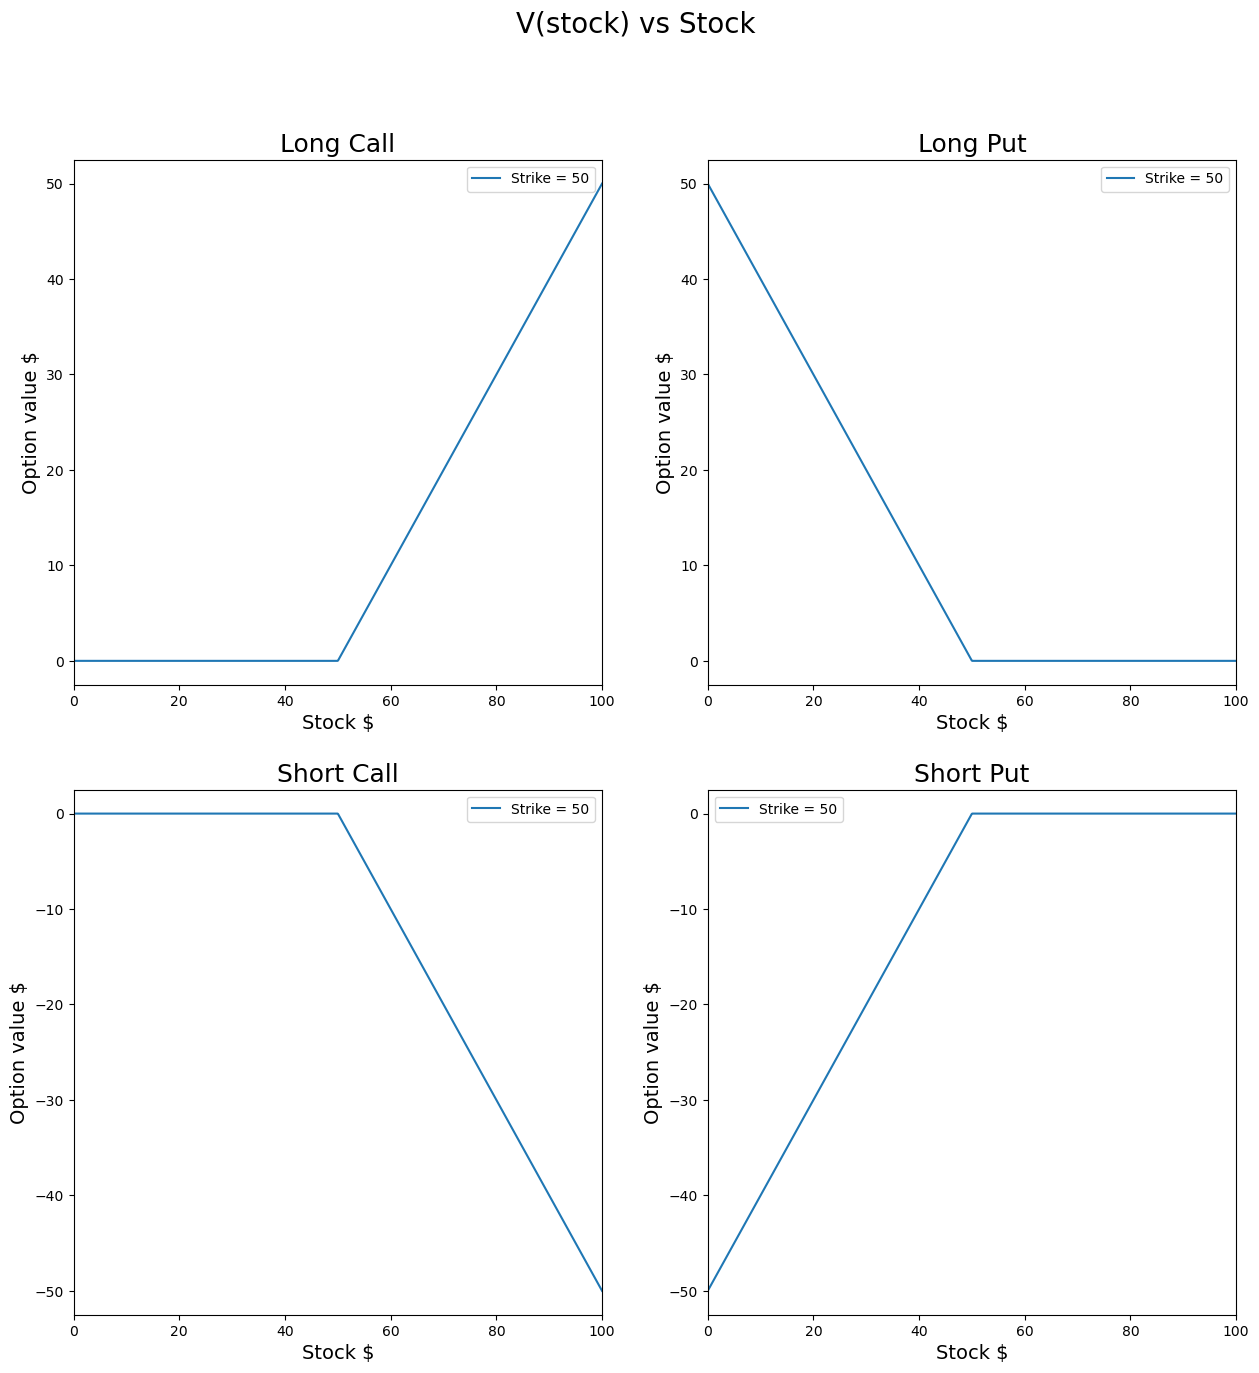

In [42]:

RATE = 0.1
def call(stock,strike):
  '''
  Call option at time T with security price s_T and strike price K
  '''
  return np.maximum(stock-strike, 0)


def put(stock, strike):
  '''
  Put option at time T with security price s_T and strike price K
  '''
  return np.maximum(strike-stock, 0)
def digital_call(stock, strike):
  '''
  Digital call option at time T with security price s_T and strike price K
  '''
  return (stock>strike)*1
def digital_put(stock,strike):
  '''
  Digital put option at time T with security price s_T and strike price K
  '''
  return (stock<strike)*1



N = 1000
stockmax = 100
strike = 50

stock = np.linspace(0,stockmax,N)


fig, axes = plt.subplots(2,2, figsize = (15,15))
fig.suptitle(r'V(stock) vs Stock', fontsize = 20)

axes[0,0].plot(stock,call(stock,strike))
axes[0,0].set_title('Long Call', fontsize = 18)

axes[0,1].plot(stock,put(stock,strike))
axes[0,1].set_title('Long Put', fontsize = 18)

axes[1,0].plot(stock,-call(stock,strike))
axes[1,0].set_title('Short Call', fontsize = 18)

axes[1,1].plot(stock,-put(stock,strike))
axes[1,1].set_title('Short Put', fontsize = 18)

for ax in axes.flat:
    ax.set(xlabel=r'Stock $',ylabel=r'Option value $',xlim = (0,stockmax))
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)
    ax.legend(["Strike = 50"])
plt.show()

















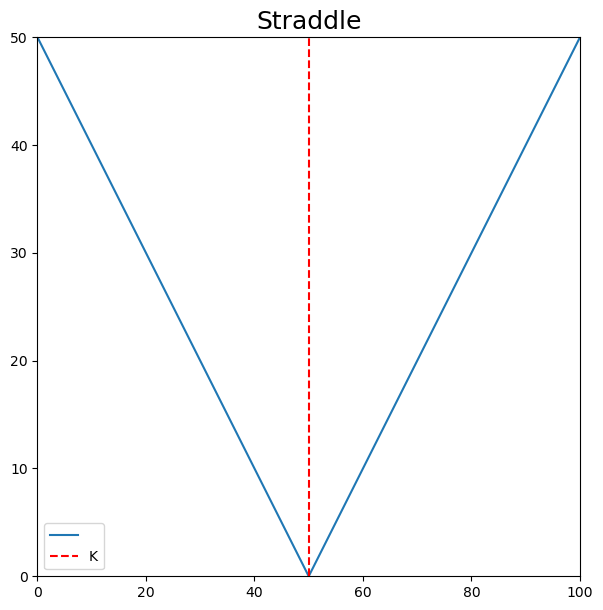

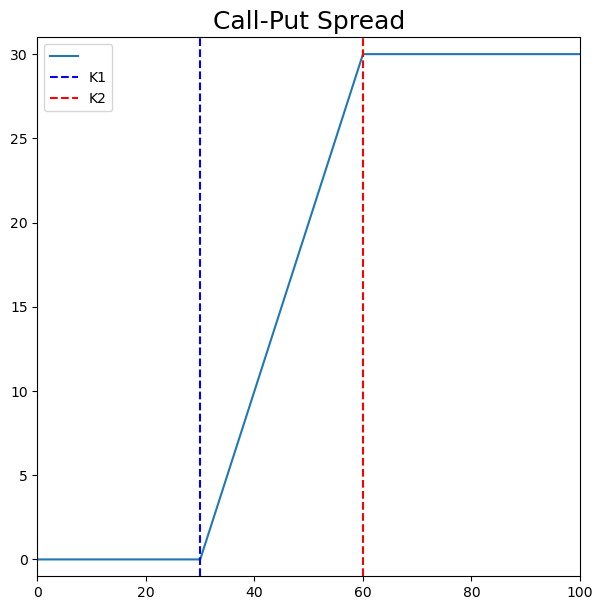

In [24]:
#straddle 
plt.figure(figsize = (7,7))
plt.plot(s_T, c(s_T,K)+p(s_T,K))
plt.title('Straddle', fontsize = 18)
plt.xlabel(r'', fontsize = 14)
plt.ylabel(r'', fontsize = 14)
plt.vlines(K, 0, 50, 'r', '--')
plt.ylim(0, 50);
plt.xlim(0,s_Tmx)
plt.legend([r'', 'K'])
plt.show()

#We indeed see that this is exactly |S_T - K|
            
            #call-put spread
K1 = 30
K2 = 60
ymin = -1
ymax = 31

plt.figure(figsize = (7,7))
plt.plot(s_T, c(s_T,K1)-c(s_T,K2))
plt.title('Call-Put Spread', fontsize = 18)
plt.xlabel(r'', fontsize = 14)
plt.ylabel(r'', fontsize = 14)
plt.ylim(ymin, ymax)
plt.xlim(0,s_Tmx)
plt.vlines(K1, ymin, ymax, 'b',  'dashed')
plt.vlines(K2, ymin, ymax, 'r',  'dashed')
plt.legend([r'', 'K1', 'K2'])
plt.show()

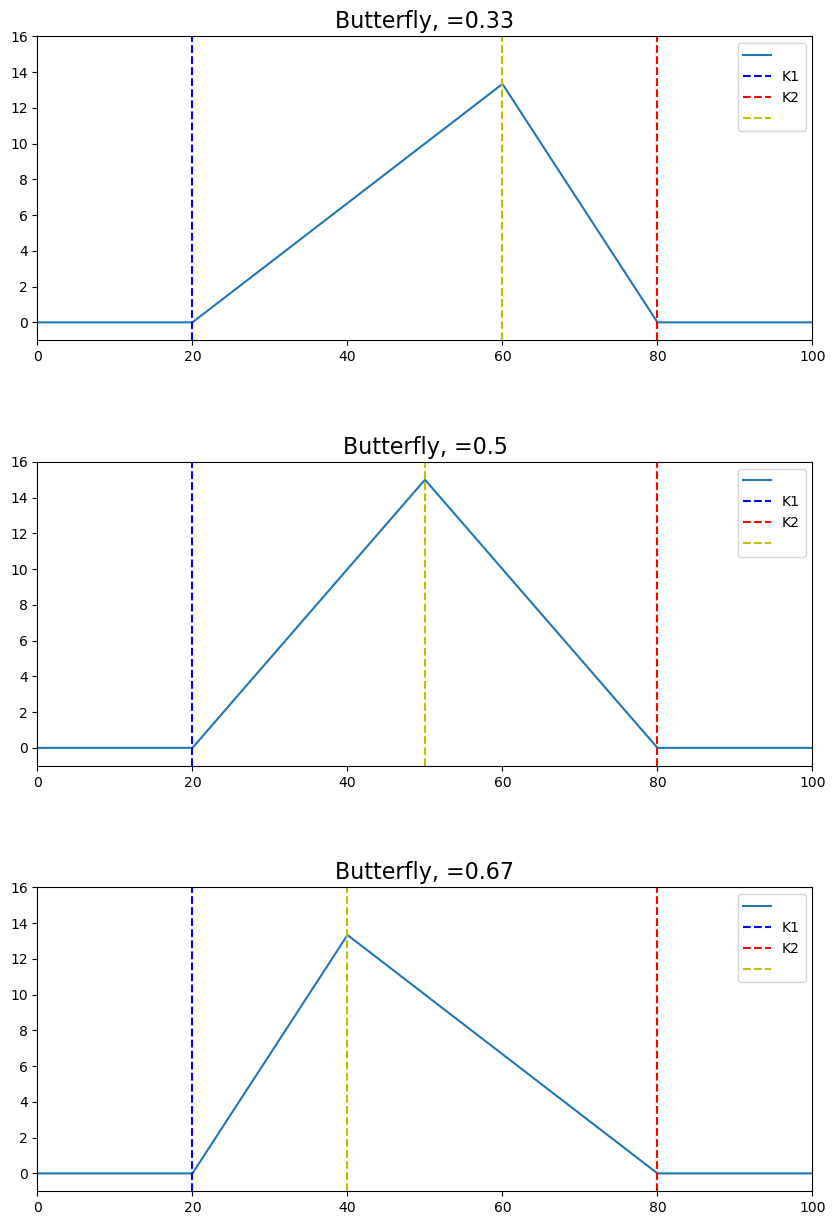

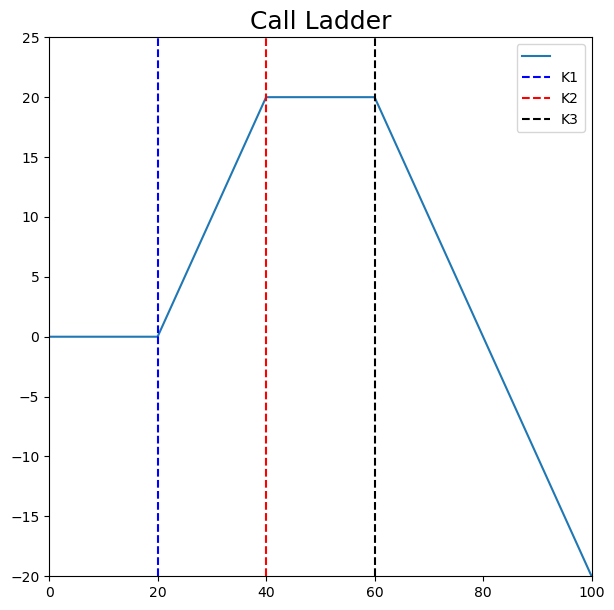

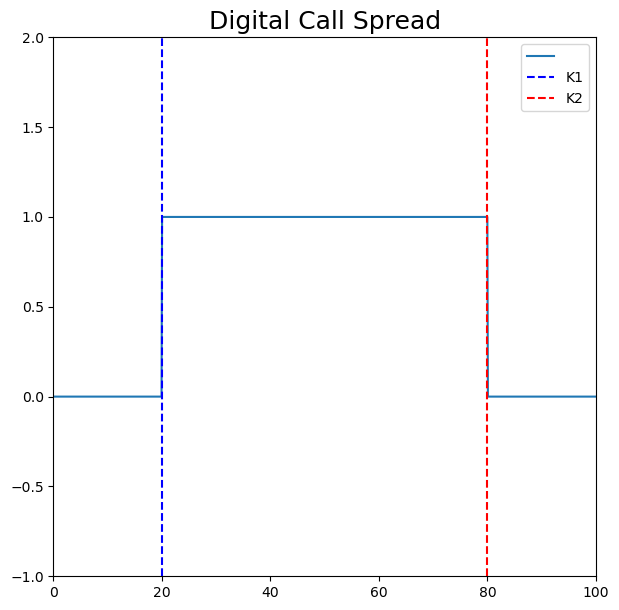

In [25]:
##butterfly
K1 = 20
K2 = 80
ymin = -1
ymax = 16
fig, axes = plt.subplots(3,1, figsize = (10,15), )
fig.subplots_adjust(hspace =0.4)

lambd = np.array([1/3, 0.5, 2/3])
K_star = lambd*K1 + (1-lambd)*K2

for i in range(len(lambd)):
    axes[i].plot(s_T, lambd[i]*c(s_T,K1)+(1-lambd[i])*c(s_T,K2)-c(s_T,K_star[i]))
    axes[i].set_title(r'Butterfly, ='+str(np.around(lambd[i],2)),fontsize = 16)
    axes[i].vlines(K1, ymin, ymax, 'b',  'dashed')
    axes[i].vlines(K2, ymin, ymax, 'r',  'dashed')
    axes[i].vlines(K_star[i], ymin, ymax, 'y',  'dashed')
    axes[i].legend([r'', 'K1', 'K2', r''])

for ax in axes.flat:
    ax.set(xlabel=r'', ylabel=r'',xlim = (0,s_Tmx), ylim = (ymin, ymax))
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)
plt.show()
                  
                  
#Call Ladder 
K1 = 20
K2 = 40
K3 = 60
ymin = -20
ymax = 25

plt.figure(figsize = (7,7))
plt.plot(s_T, c(s_T,K1)-c(s_T,K2)-c(s_T, K3))
plt.title('Call Ladder', fontsize = 18)
plt.xlabel(r'', fontsize = 14)
plt.ylabel(r'', fontsize = 14)
plt.ylim(ymin, ymax)
plt.xlim(0,s_Tmx)
plt.vlines(K1, ymin, ymax, 'b',  'dashed')
plt.vlines(K2, ymin, ymax, 'r',  'dashed')
plt.vlines(K3, ymin, ymax, 'k',  'dashed')
plt.legend([r'', 'K1', 'K2', 'K3'])
plt.show()
            

#digital call spread
K1 = 20
K2 = 80
ymin = -1
ymax = 2
plt.figure(figsize = (7,7))
plt.plot(s_T, d_c(s_T,K1)-d_c(s_T,K2))
plt.title('Digital Call Spread', fontsize = 18)
plt.xlabel(r'', fontsize = 14)
plt.ylabel(r'', fontsize = 14)
plt.ylim(ymin, ymax)
plt.xlim(0,s_Tmx)
plt.vlines(K1, ymin, ymax, 'b',  'dashed')
plt.vlines(K2, ymin, ymax, 'r',  'dashed')
plt.legend([r'', 'K1', 'K2'])
plt.show()

In [26]:

N = 5
SEED = 25

r1 = 0.05
u1 = 1.1
d1 = 1.01
S0 = 1

p_tilda1 = ((1+r1)-d1)/(u1-d1)


npr.seed(25)
#We can get K by K = (1+R)^N * S0, like putting S0 into the money market
K1 = S0*(1+r1)**N

def ER_call(Sn, K = K1):
    return np.maximum(0, Sn-K)

def get_all_paths(N):
    #Thanks to https://stackoverflow.com/questions/22227595/
    #    convert-integer-to-binary-array-with-suitable-padding
    d = np.arange(0,2**N)
    m = N
    return (((d[:,None] & (1 << np.arange(m)))) > 0).astype(int)

def V0_all_paths(N, V, K, p_tilda, u, d, r, S0= S0):

    #Get all the paths and find the number of heads in each
    W_ns = get_all_paths(N)
    numH= np.sum(W_ns, axis = 1)
    #calculate the probabilities and the S_N for each path
    probs = (p_tilda**numH) * (1-p_tilda)**(N-numH)
    SN = (u**numH)*(d)**(N-numH)*S0

    #finish up with an expectation over V_N going over all paths
    V_N = V(SN,K)
    V0 = np.sum((V_N*probs)/(1+r)**N)
    return V0

V0_all_paths(N, ER_call, K1, p_tilda1, u1, d1, r1)

0.039031475205349914

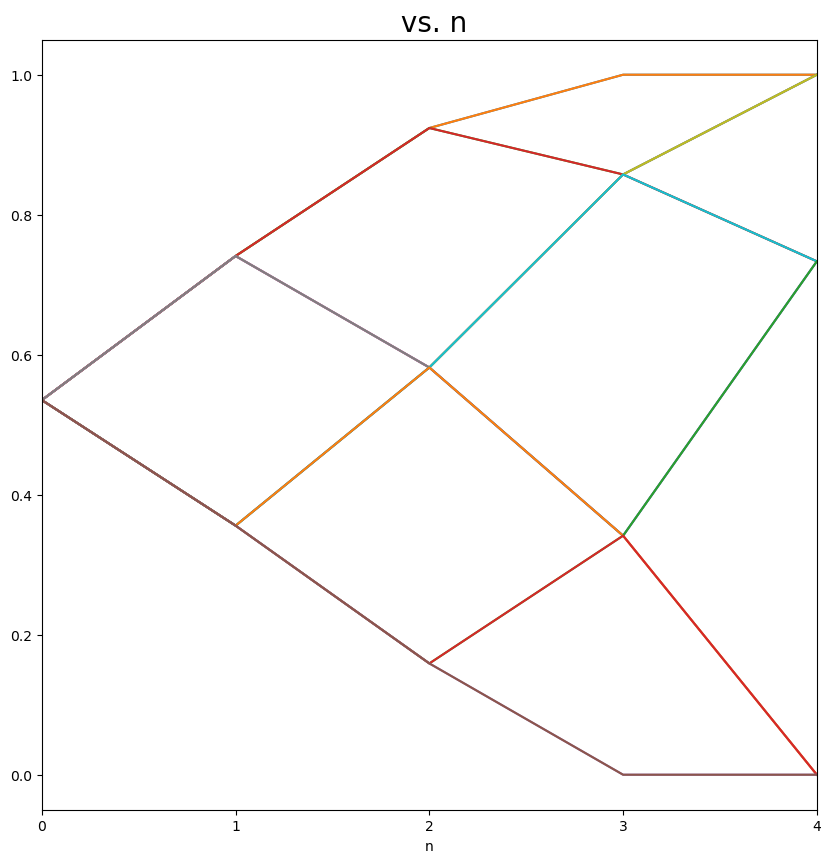

In [30]:
def repl_portf(Vn_H, Vn_T, u, d, r, p_tilda, Wn = np.empty(0), S0= S0):
    Sn = S0
    if len(Wn) != 0:
        numH = np.sum(Wn)
        Sn = (u**numH)*(d)**(len(Wn)-numH)*S0
    Snp1H = Sn*u
    Snp1T = Sn*d

    delta_n = (Vn_H - Vn_T)/(Snp1H - Snp1T)
    V_n = 1/(1+r)*np.sum(Vn_H*p_tilda +Vn_T*(1-p_tilda))

    return delta_n, V_n

def V0_recurse (N, V, u, d, r, p_tilda, deltas = None, Wn = np.empty(0),  S0 = S0):
    #base case: if path is N long, compute S_N and then V(S_N) and return 
    if deltas is None: 
        deltas = np.full(shape = (2**(N-1), N), fill_value = np.inf)
    if len(Wn) == N:
        numH = np.sum(Wn)
        SN = (u**numH)*(d)**(N-numH)*S0
        return V(SN), deltas
    
    numH = np.sum(Wn)
    Snp1H = S0*u**(numH+1)*d**(len(Wn)-numH)
    Snp1T = S0*u**(numH)*d**(len(Wn)+1-numH)

    #from these values, get the V_{n+1}s recursively, keep the delta matrix
    V_np1H, deltas = V0_recurse (N, V, u, d, r, p_tilda,
                               deltas, np.append(Wn, np.array(1)))
    V_np1T, deltas = V0_recurse (N, V,u, d, r, p_tilda,
                               deltas, np.append(Wn, np.array(0)))

    #return V_0
    delta_n, V_0 = repl_portf(V_np1H, V_np1T, u, d, r, p_tilda, Wn)

    #A bit of a hack to get the deltas in a nice format
    #Loop through the possible value that the delta should go to until
    #one isn't infinity. Once found, insert the delta_n there. 
    #This generates a matrix where all rows are different paths
    for i in range(0, deltas.shape[0], 2**(N-len(Wn)-1)):
        if not(np.isfinite(deltas[i, len(Wn)])):
            deltas[i:i+2**(N-len(Wn)-1), len(Wn)] = delta_n
            break

    return (V_0, deltas)


(V_0, deltas) = V0_recurse(5, ER_call,u1, d1, r1, p_tilda1)
V_0

#plotting
plt.figure(figsize = (10,10))
for i in range(deltas.shape[0]):
    plt.plot(np.arange(0,5), deltas[i,:])
    plt.xlabel('n')
plt.ylabel(r'', fontsize = 14)
plt.title(r' vs. n', fontsize = 20)
plt.xlim(0, N-1)
plt.xticks(np.arange(0,N))
#plt.ylim(-0.1,1.1)
plt.show()

In [31]:

def MC(N, m, u, d, r, p, V = None, K = K1, S0 = S0, seed = SEED):
    npr.seed(SEED)
    numHs = npr.binomial(N, p, size= m)
    S_N = (u**numHs)*(d)**(N-numHs)*S0
    if V is None:
        value =  np.sum(S_N)/(m*(1+r)**N)
    else:
        value =  np.sum(V(S_N, K))/(m*(1+r)**N)
    return value


M_vals = [1,5,10,32, 1000]

S_0 = np.ndarray(shape = (len(M_vals)))
V_0 = np.ndarray(shape = (len(M_vals)))
for i,m in enumerate(M_vals):
    S_0[i] = MC(N,m, u1, d1, r1, p_tilda1)
    V_0[i] = MC(N,m, u1, d1, r1, p_tilda1, ER_call)
  
print('M:\t\t\t1\t  5\t    10\t       32\t 1000')
print('S_0 Estimations:', S_0)
print('V_0 Estimations:', V_0)


M:			1	  5	    10	       32	 1000
S_0 Estimations: [1.06383508 0.97821834 0.97821834 0.9902049  1.00014637]
V_0 Estimations: [0.06383508 0.01276702 0.01276702 0.02311514 0.03809687]


In [32]:

N = 100
r2 = 1e-3
u2 = 1+5e-3
d2 = 1+1e-4

p_tilda2 = ((1+r2)-d2)/(u2-d2)
K2 = S0*(1+r2)**N

##Checking for different M
M_vals2 = [2,4,8,16,32]

S_0 = np.ndarray(shape = (len(M_vals2)))
for i,m in enumerate(M_vals2):
    S_0[i] = MC(N,m, u2, d2, r2, p_tilda2)


print('M:\t\t\t2\t  4\t    8\t       16\t  32')
print('S_0 Estimations:', S_0)


V_0 = np.ndarray(shape = (len(M_vals)))
for i,m in enumerate(M_vals):
    V_0[i] = MC(N,m, u2, d2, r2, p_tilda2, ER_call, K2)


print('M:\t\t\t1\t  5\t    10\t       32\t 1000')
print('V_0 Estimations:', V_0)



S10_H = S0*u2**10
S10_T = S0*d2**10

V_10H = np.ndarray(shape = (len(M_vals)))
V_10T = np.ndarray(shape = (len(M_vals)))
for i,m in enumerate(M_vals):
    V_10H[i] = MC(N-10,m, u2, d2, r2, p_tilda2, ER_call, K2, S10_H)
    V_10T[i] = MC(N-10,m, u2, d2, r2, p_tilda2, ER_call, K2, S10_T )


print('M:\t\t\t\t\t   1\t      5\t\t10\t    32\t     1000')
print('V_10 Estimations, previous 10 Heads:', V_10H)
print('V_10 Estimations, previous 10 Tails:', V_10T)


S_0_09 = np.ndarray(shape = (len(M_vals)))
V_0_09 = np.ndarray(shape = (len(M_vals)))
S_0_11 = np.ndarray(shape = (len(M_vals)))
V_0_11 = np.ndarray(shape = (len(M_vals)))

for i,m in enumerate(M_vals):
    S_0_09[i] =  MC(N,m, u2, d2, r2, p_tilda2*0.9)
    V_0_09[i] = MC(N,m, u2, d2, r2, p_tilda2*0.9, ER_call, K2)
    S_0_11[i] =  MC(N,m, u2, d2, r2, p_tilda2*1.1)
    V_0_11[i] =  MC(N,m, u2, d2, r2, p_tilda2*1.1, ER_call, K2)
  
print('M:\t\t\t\t  1\t      5\t\t 10\t   32\t     1000')
print('S_0 Estimations for 0.9*P^~:', S_0_09)
print('V_0 Estimations for 0.9*P^~:', V_0_09)
print('\n')
print('S_0 Estimations for 1.1*P^~:', S_0_11)
print('V_0 Estimations for 1.1*P^~:', V_0_11)



def lookback_option(Wn, u, d, r, S0 =S0):
    '''Assume we have a path, Wn that is non-empty'''
    N = len(Wn)
    n = np.arange(1,N+1)

    #number of Hs at each timestamp
    numH = np.cumsum(Wn)
    #Sn at each time
    Sns = (u**numH)*(d)**(n-numH)*S0

    #Including the time value of money forward
    Sn_w = Sns*(1+r)**(N-n)

    #lookback option equation
    return np.max(Sn_w[:-1] - Sn_w[-1])


def V0_recurse_path_dep (N, V, u, d, r, p_tilda, Wn = np.empty(0), S0 = S0):
    #base case: if path is N-1 long, compute S_N and then V(S_N) and return 
    if len(Wn) == N:
        return V(Wn, u, d, r)

    numH = np.sum(Wn)
    Snp1H = S0*u**(numH+1)*d**(len(Wn)-numH)
    Snp1T = S0*u**(numH)*d**(len(Wn)+1-numH)

    #from these values, get the V_{n+1}s recursively
    V_np1H = V0_recurse_path_dep (N, V, u, d, r, p_tilda, np.append(Wn, np.array(1)))
    V_np1T = V0_recurse_path_dep (N, V,u, d, r, p_tilda, np.append(Wn, np.array(0)))
    #return V_0
    _, V_0 = repl_portf(V_np1H, V_np1T, u, d, r, p_tilda, Wn)

    return V_0


def MC_path_dep(N, m, u, d, r, p, V = None, S0 = S0, seed = SEED):
    npr.seed(SEED)
    Wns = npr.binomial(1, p, size = (m, N))
    VT = np.ndarray(shape = (m))
    for i in range(m):
        VT[i] = V(Wns[i], u, d, r, S0 =S0)
    return np.sum(VT)/(m*(1+r)**N)

N = 5
V_0 = V0_recurse_path_dep(N, lookback_option,u1, d1, r1, p_tilda1)
V_0
     
    


M_val = [1, 10, 100, 1_000, 10_000]

V0_MC = np.ndarray(shape = (len(M_val)))
M_str = ''
for i, m in enumerate(M_val):
    V0_MC[i] = MC_path_dep(N, m, u1, d1, r1, p_tilda1, lookback_option)
    M_str += str(m) + '        '

print('M:\t  ', M_str)
print('V_0:', V0_MC)

N = 100

M_val = [1, 10, 100, 1_000, 10_000]
V0_MC = np.ndarray(shape = (len(M_val)))
V0_MC_09 = np.ndarray(shape = (len(M_val)))
V0_MC_11 = np.ndarray(shape = (len(M_val)))

M_str = ''
for i, m in enumerate(M_val):
    V0_MC[i] = MC_path_dep(N, m, u2, d2, r2, p_tilda2, lookback_option)
    V0_MC_09[i] = MC_path_dep(N, m, u2, d2, r2, (p_tilda2*0.9), lookback_option)
    V0_MC_11[i] = MC_path_dep(N, m, u2, d2, r2, (p_tilda2*1.1), lookback_option)

    M_str += str(m) + '        '

print('M:\t\t\t\t     ', M_str)
print('E_{p0}(V_N^~), p0 = 0.9*p^~:\t', V0_MC_09)
print('V_0:\t\t\t\t', V0_MC)
print('E_{p0}(V_N^~), p0 = 1.1*p^~:\t', V0_MC_11)


M:			2	  4	    8	       16	  32
S_0 Estimations: [1.01281716 0.9993634  0.99689727 0.99534967 0.99906657]
M:			1	  5	    10	       32	 1000
V_0 Estimations: [0.02271723 0.00512687 0.00363823 0.00504928 0.00761259]
M:					   1	      5		10	    32	     1000
V_10 Estimations, previous 10 Heads: [0.06413577 0.03932609 0.03776749 0.04008627 0.04148629]
V_10 Estimations, previous 10 Tails: [0.01289704 0.00257941 0.0012897  0.00249967 0.00376811]
M:				  1	      5		 10	   32	     1000
S_0 Estimations for 0.9*P^~: [1.01276878 0.98937749 0.987908   0.99025389 0.99139292]
V_0 Estimations for 0.9*P^~: [0.01276878 0.00255376 0.00127688 0.00263449 0.00381544]


S_0 Estimations for 1.1*P^~: [1.03276341 1.00792756 1.00594719 1.00766307 1.00936718]
V_0 Estimations for 1.1*P^~: [0.03276341 0.00968986 0.00847831 0.01027257 0.0132871 ]
M:	   1        10        100        1000        10000        
V_0: [0.12071164 0.04888633 0.05064523 0.04113098 0.04386696]
M:				      1        10        100        1000  

In [ ]:
#sample = normal(loc=50, scale=5, size=1000)
#sample_mean = mean(sample)
#sample_std = std(sample)
#dist = norm(sample_mean, sample_std)

#distribution_function = lambda x: norm.pdf(x, 0.1)
#x1 = 1
#x2 = 2

#integrate.quad(distribution,x1,x2)[0]


#step = 0.001
#whole_x = np.arange(-4, 4, step)
#whole_y = list(map(distribution_function, whole_x))

#needed_x = np.arange(x1, x2, step)
#needed_y = list(map(distribution_function, needed_x))
#plt.plot(whole_x, whole_y)
#plt.fill_between(needed_x, needed_y)
#plt.show()